In [1]:
from torch.utils.data import DataLoader
import torch
import numpy as np
from nbeats_pytorch.model import NBeatsNet as NBeatsNet
from torch.nn import functional as F
import pandas as pd
import matplotlib.pyplot as plt
from torch import optim
import warnings
import pickle
import os
warnings.filterwarnings("ignore" , message="Setting Attributes")

# Define save function ourselves
def save(model, filepath):
    """Save model to filepath"""
    dirname = os.path.dirname(filepath)
    if dirname:  # ‡∏ñ‡πâ‡∏≤‡∏°‡∏µ directory path
        os.makedirs(dirname, exist_ok=True)
    torch.save(model.state_dict(), filepath)

In [2]:
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)

# Configuration parameters
forecast_length = 90
backcast_length = 4 * forecast_length
batch_size = 16

def data_generator(x, y, size):
    assert len(x) == len(y), "Input and output data must have the same length"
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii+size], y[ii:ii+size]))
    for batch in batches:
        yield batch

In [4]:
transport_data = pd.read_csv('../../data/data_adjustmented.csv', parse_dates=['‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà'])
data = transport_data['‡∏£‡∏ñ‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡∏™‡∏≤‡∏¢‡∏™‡∏µ‡∏ô‡πâ‡∏≥‡πÄ‡∏á‡∏¥‡∏ô'].values.flatten()  # Use .flatten() to convert to 1D
data

array([236053, 341059, 373005, ..., 488170, 510420, 520075], dtype=int64)

Generated 1623 samples
Train samples: 1298, Test samples: 325
Normalization constant: 555976
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @1796479671216
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @1796479670928
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @1796479667952
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @1796479667904
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @1796479668336
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @1796479664592


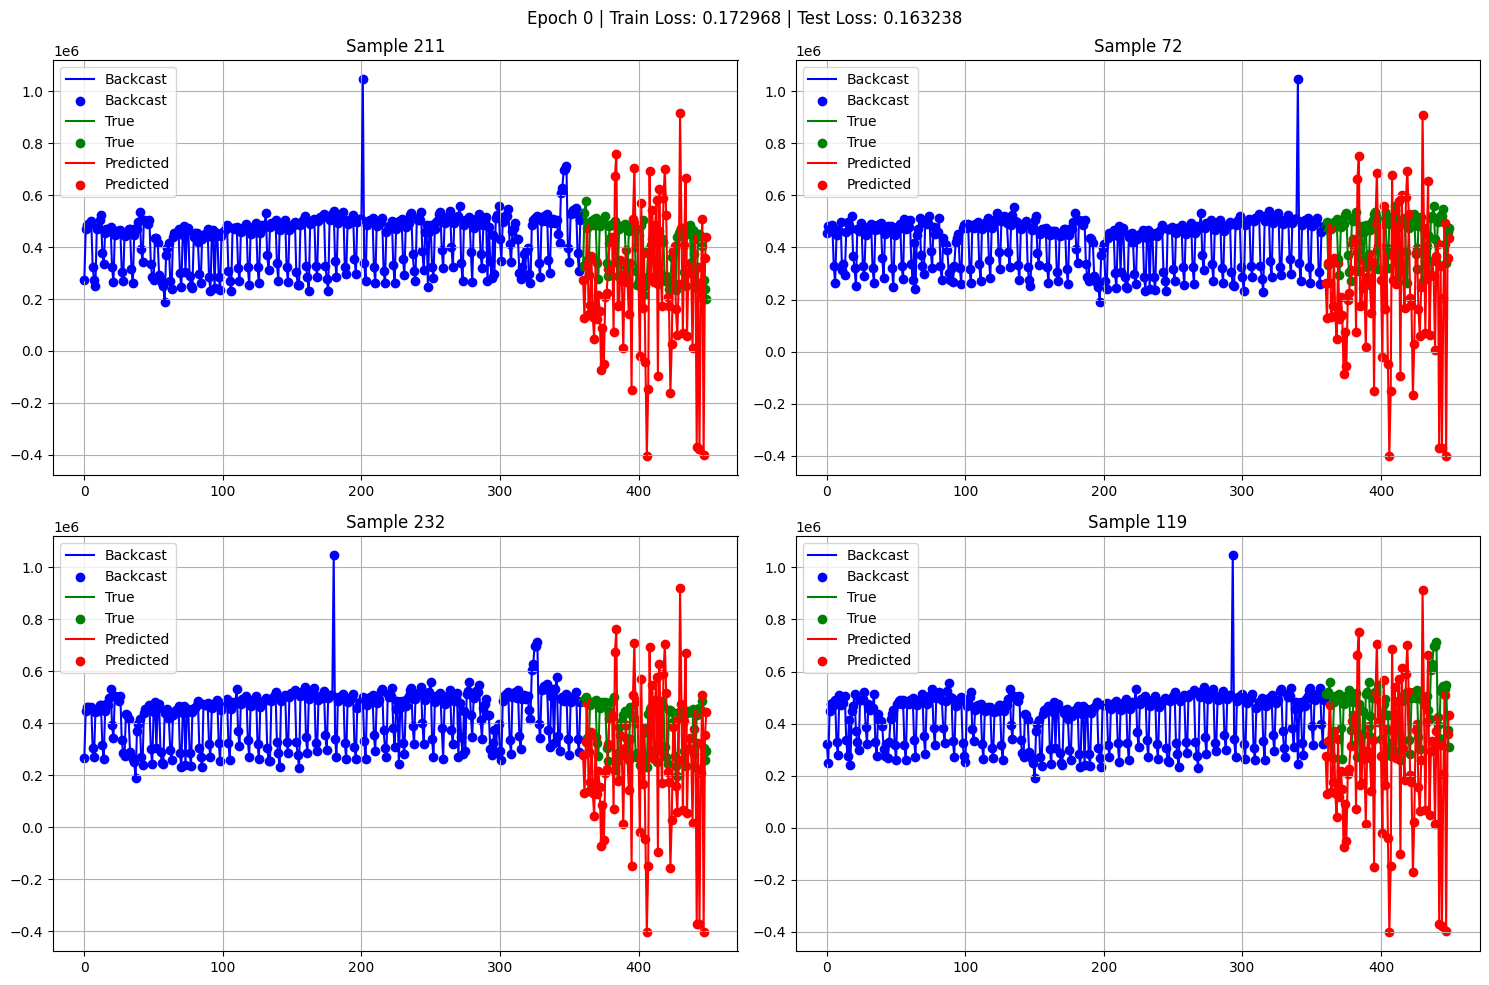

epoch = 0000, grad_step = 000082, train_loss = 172.968, test_loss = 163.238, best_test_loss = 163.238


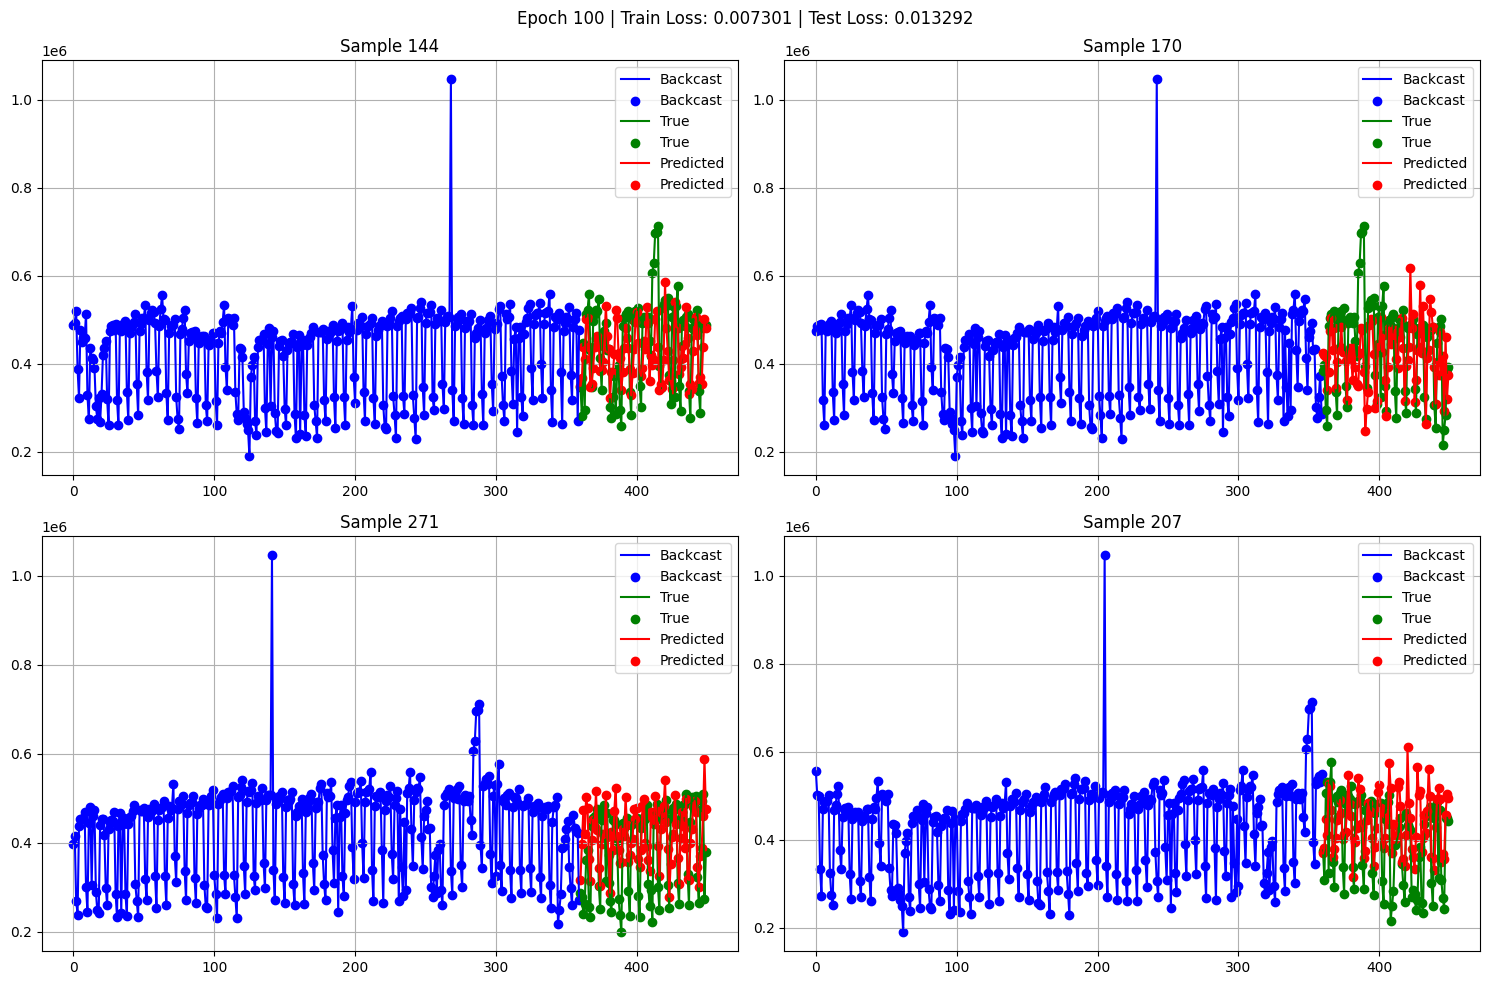

epoch = 0100, grad_step = 008282, train_loss = 7.301, test_loss = 13.292, best_test_loss = 13.292


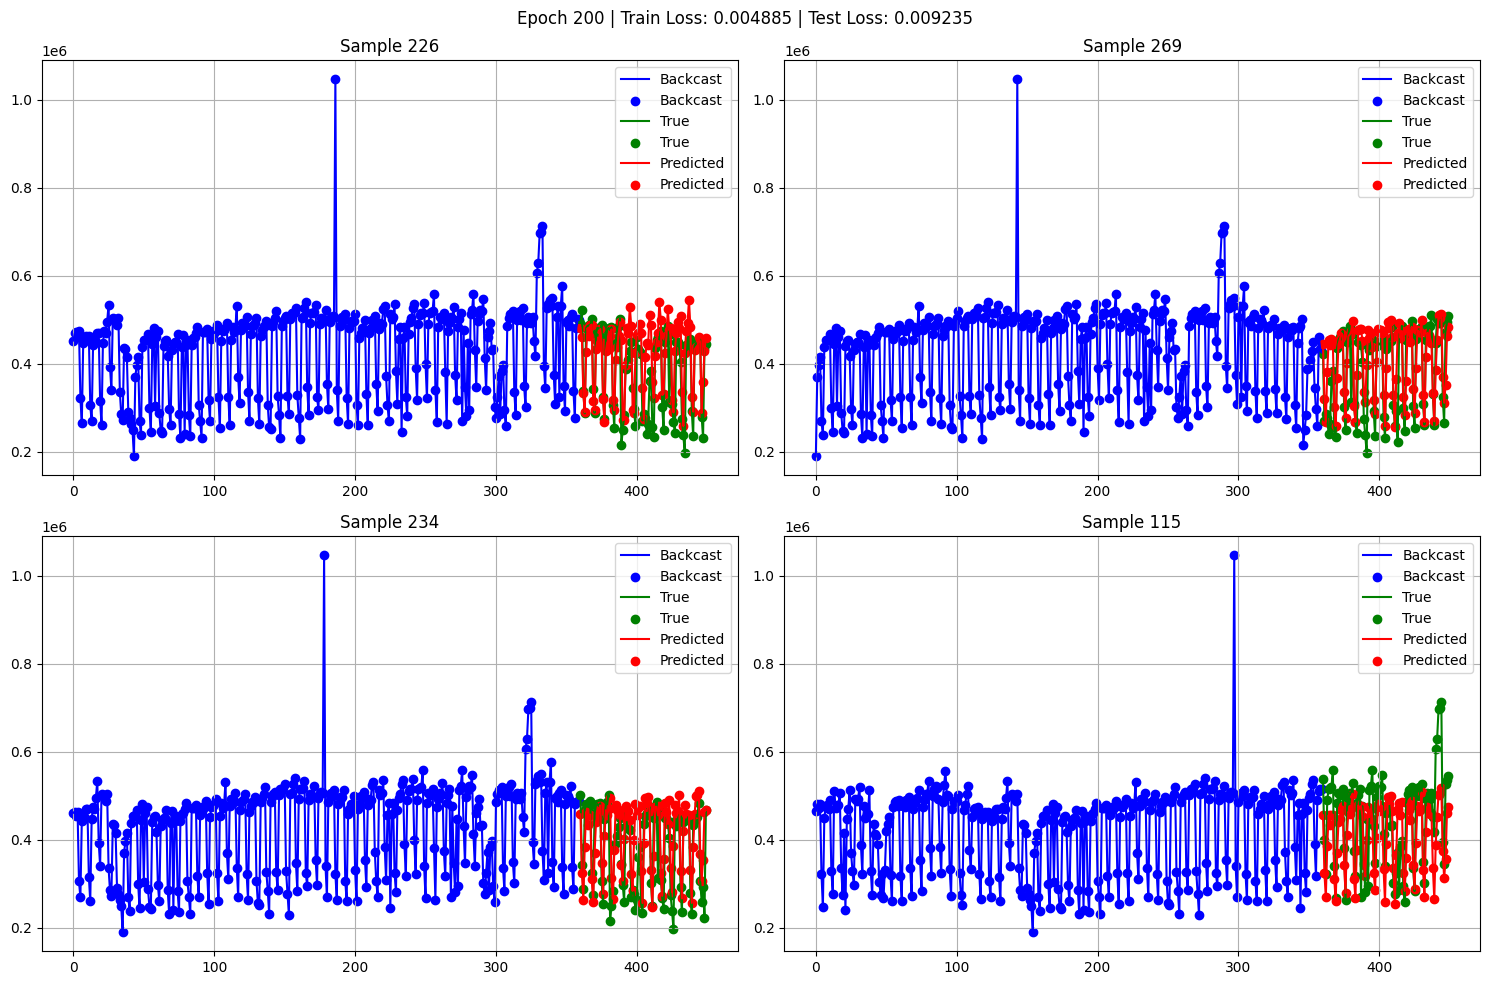

epoch = 0200, grad_step = 016482, train_loss = 4.885, test_loss = 9.235, best_test_loss = 9.053


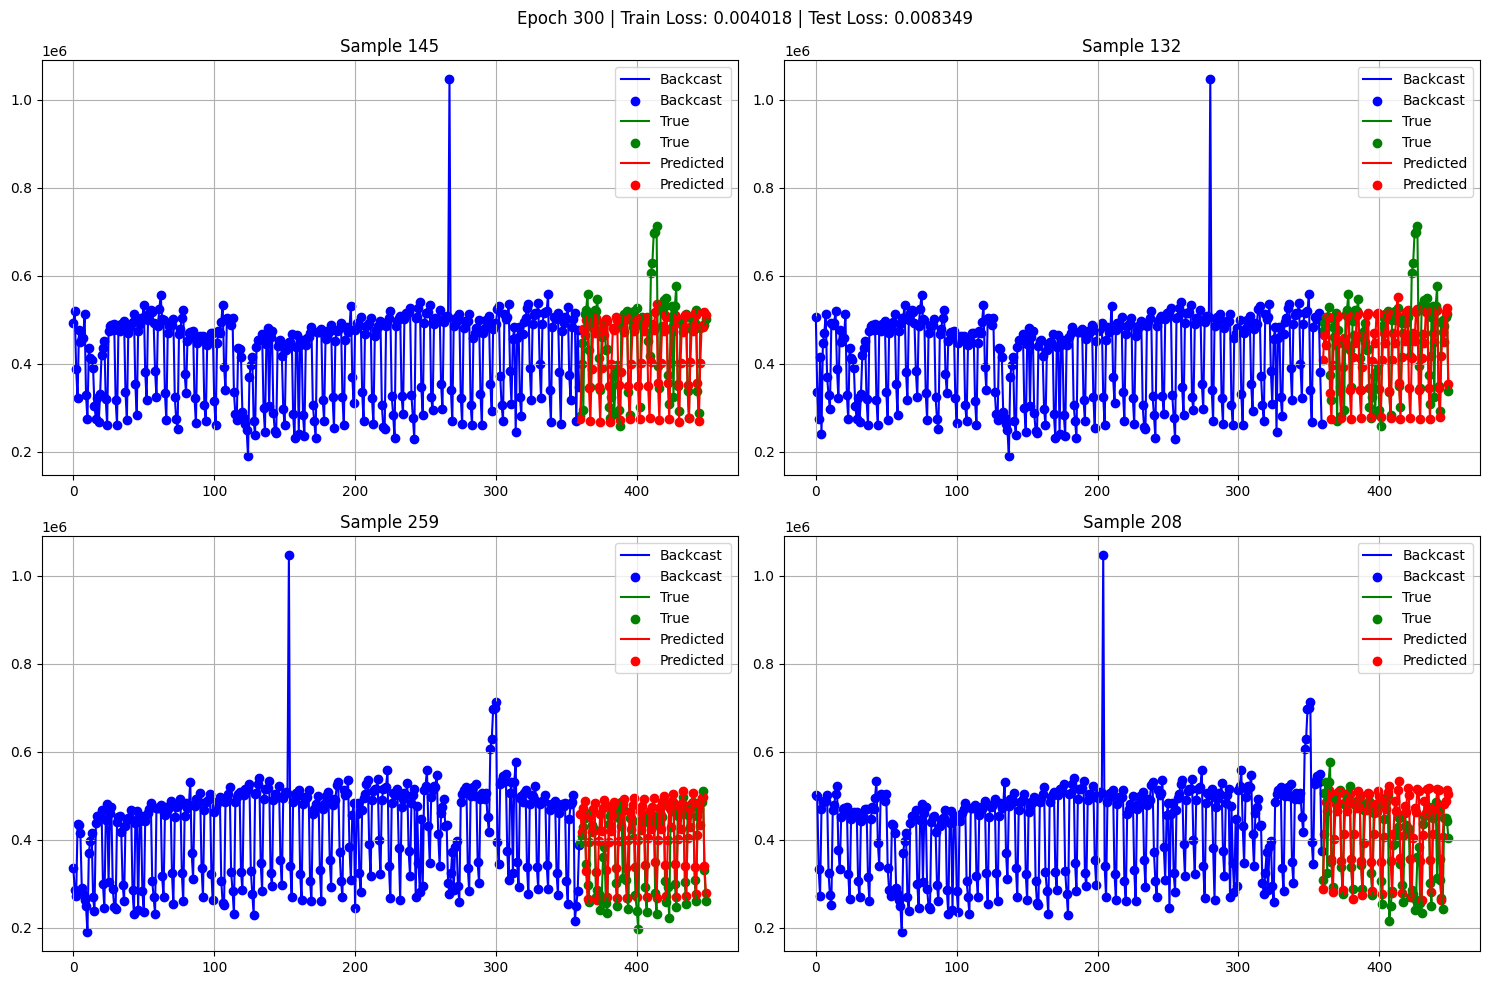

epoch = 0300, grad_step = 024682, train_loss = 4.018, test_loss = 8.349, best_test_loss = 8.283


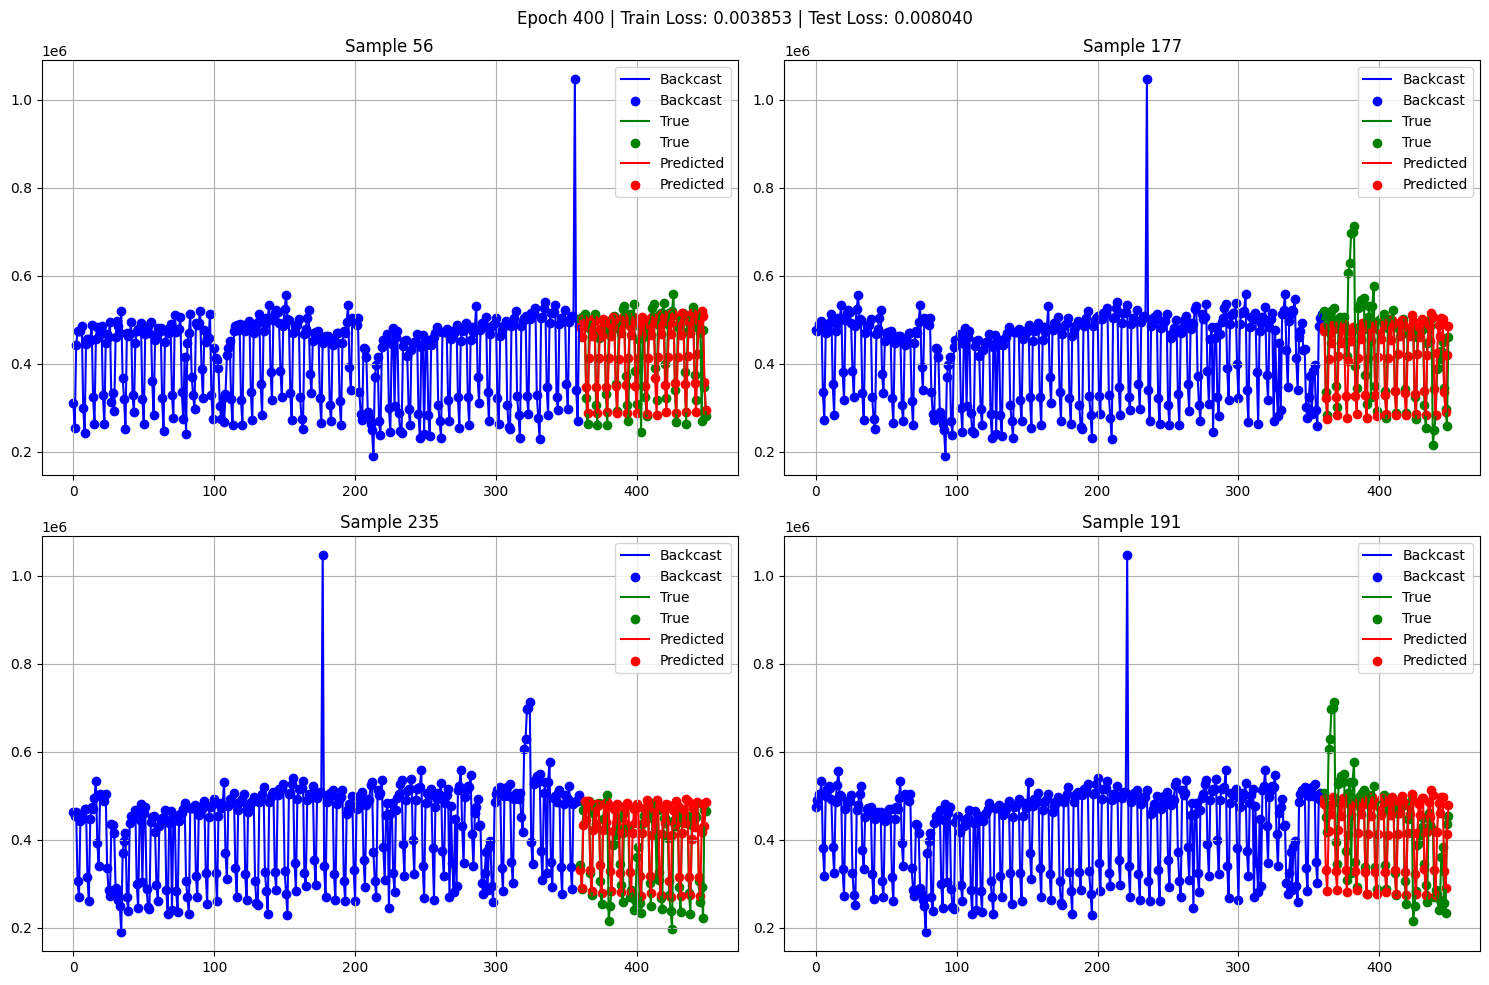

epoch = 0400, grad_step = 032882, train_loss = 3.853, test_loss = 8.040, best_test_loss = 7.988


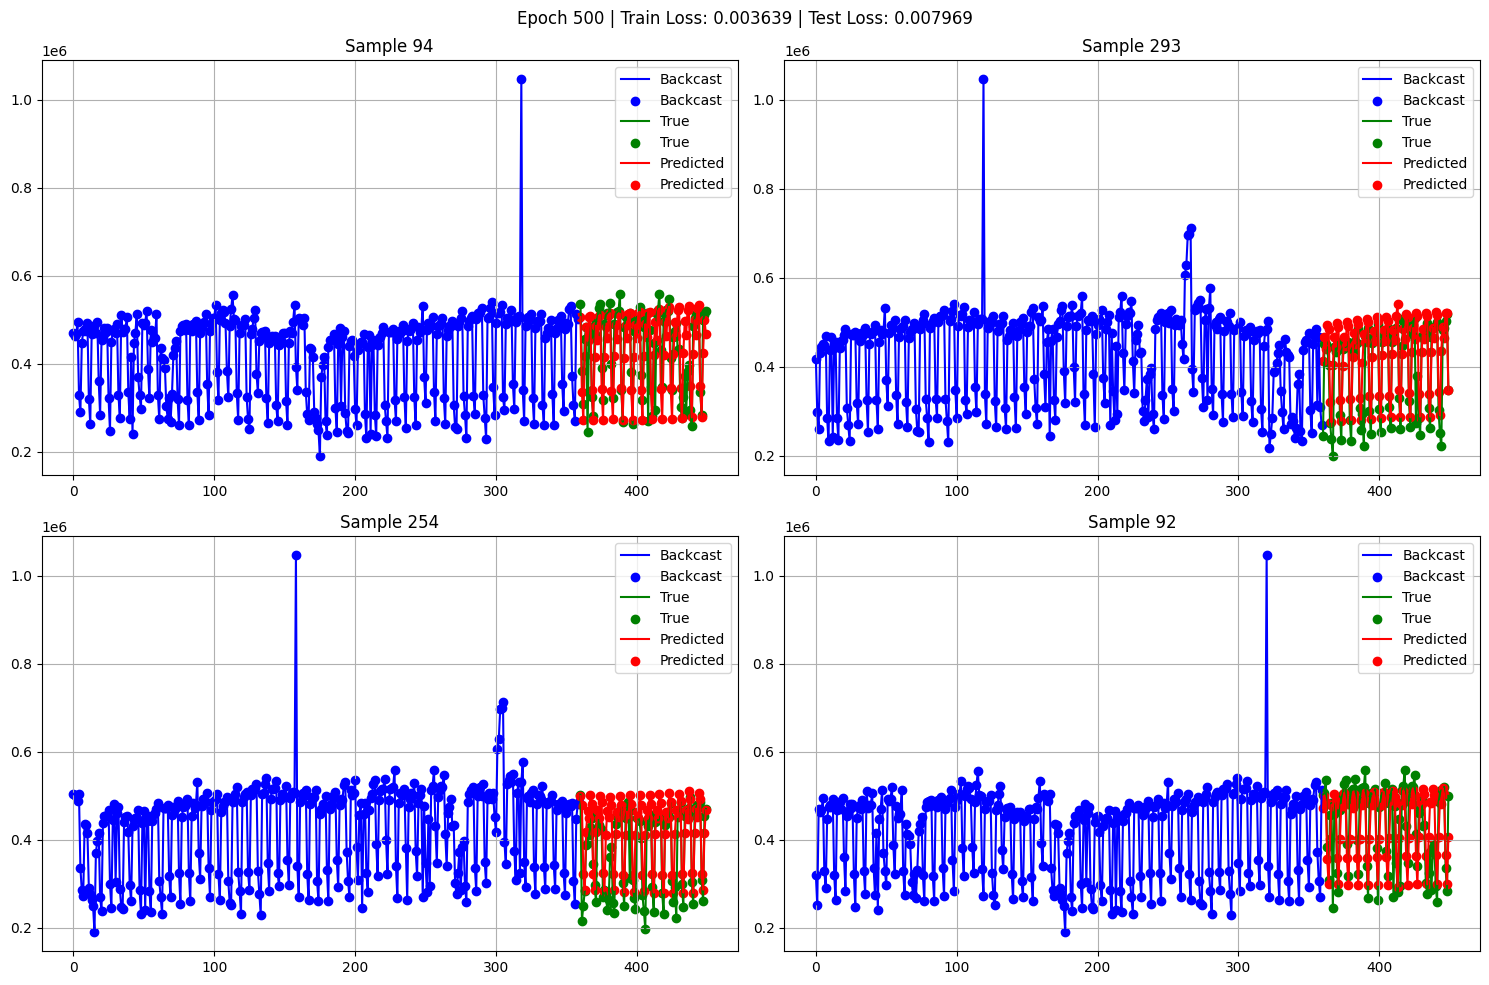

epoch = 0500, grad_step = 041082, train_loss = 3.639, test_loss = 7.969, best_test_loss = 7.910


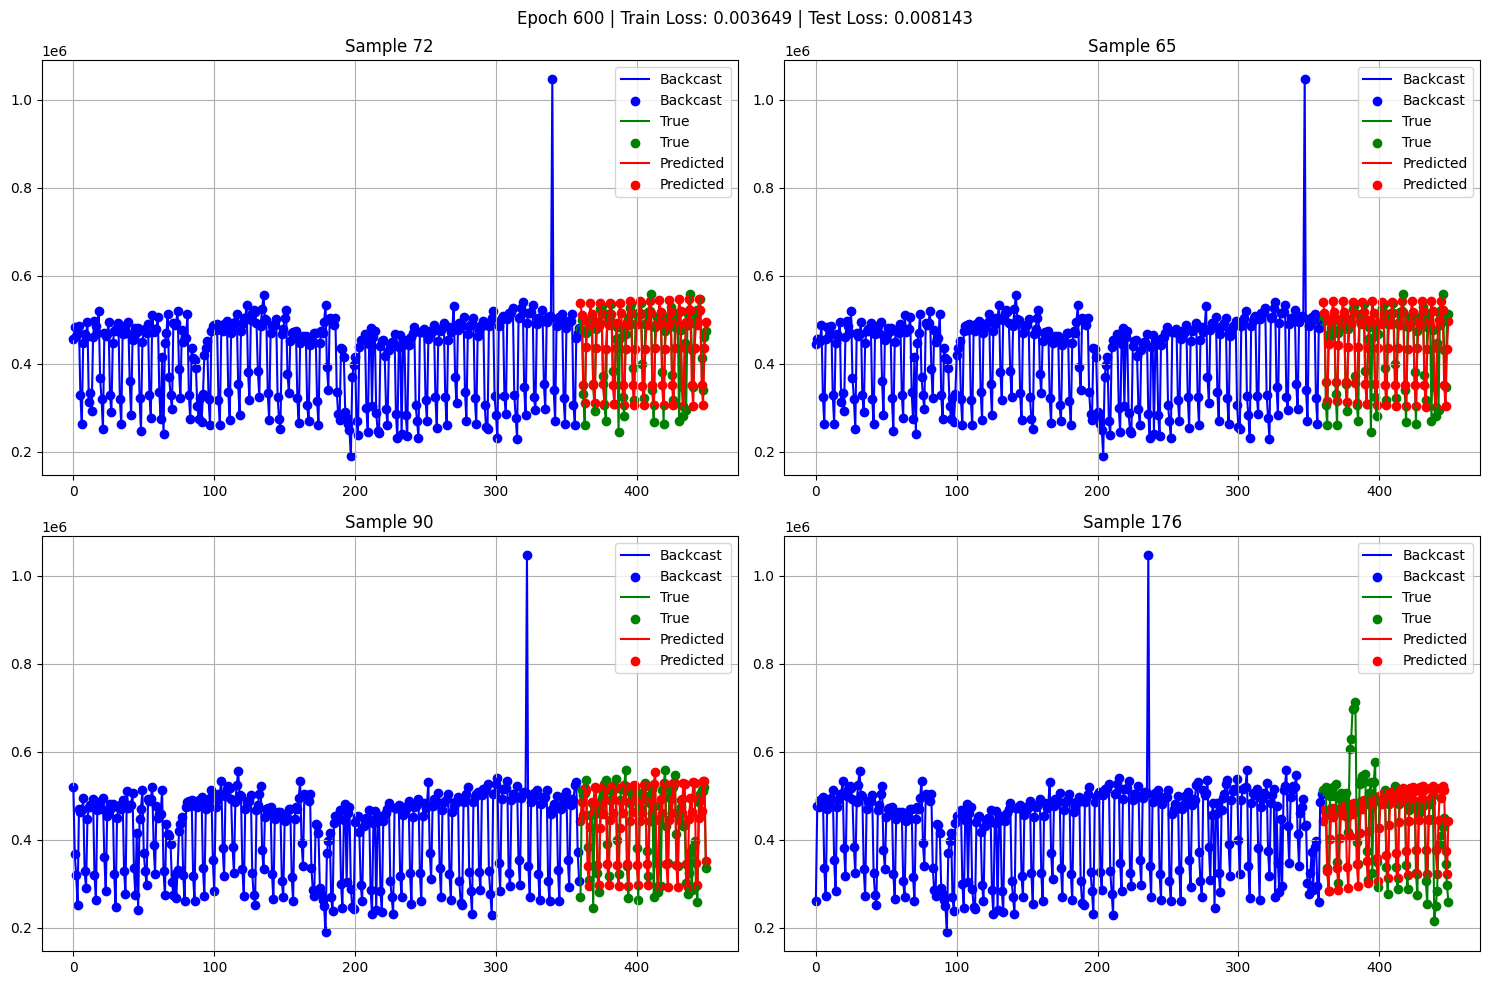

epoch = 0600, grad_step = 049282, train_loss = 3.649, test_loss = 8.143, best_test_loss = 7.893


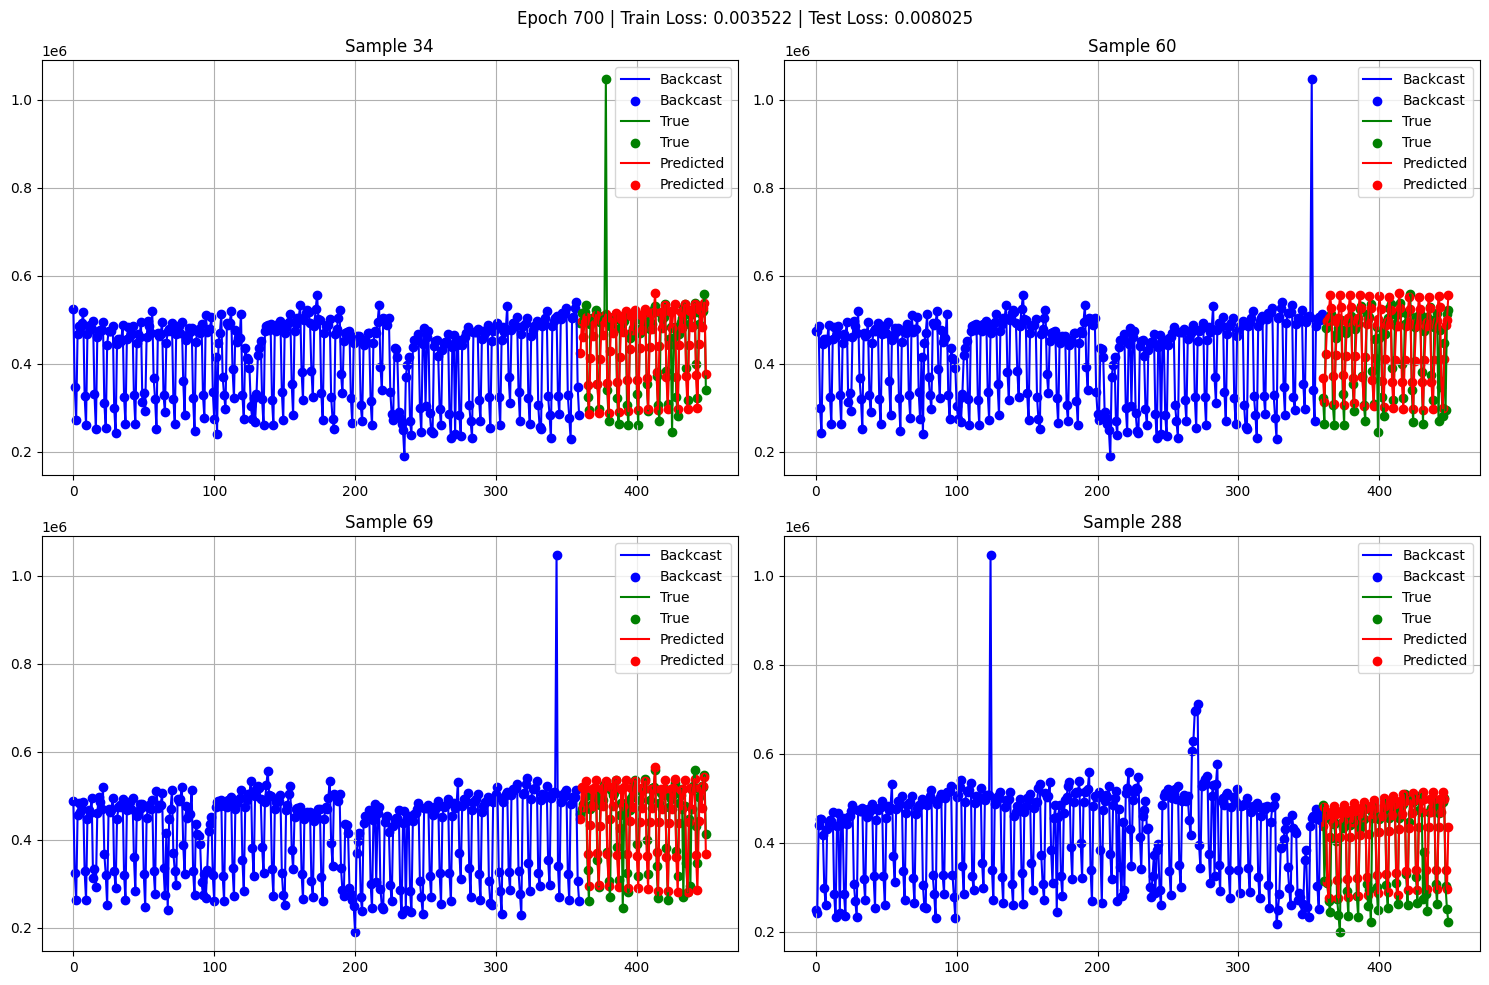

epoch = 0700, grad_step = 057482, train_loss = 3.522, test_loss = 8.025, best_test_loss = 7.893


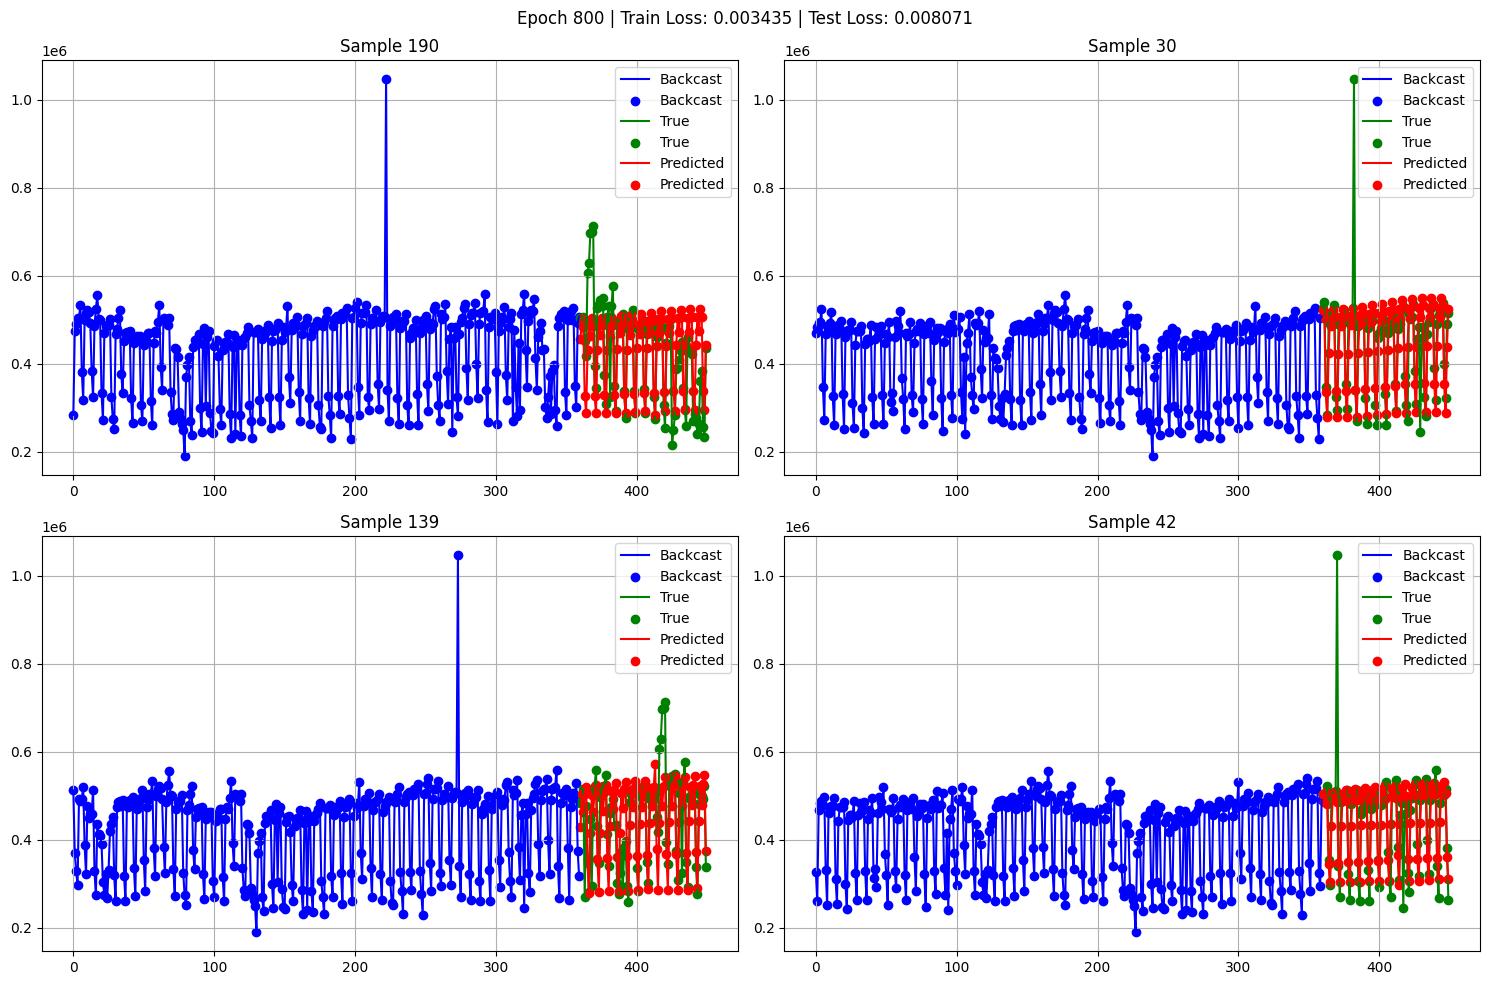

epoch = 0800, grad_step = 065682, train_loss = 3.435, test_loss = 8.071, best_test_loss = 7.893


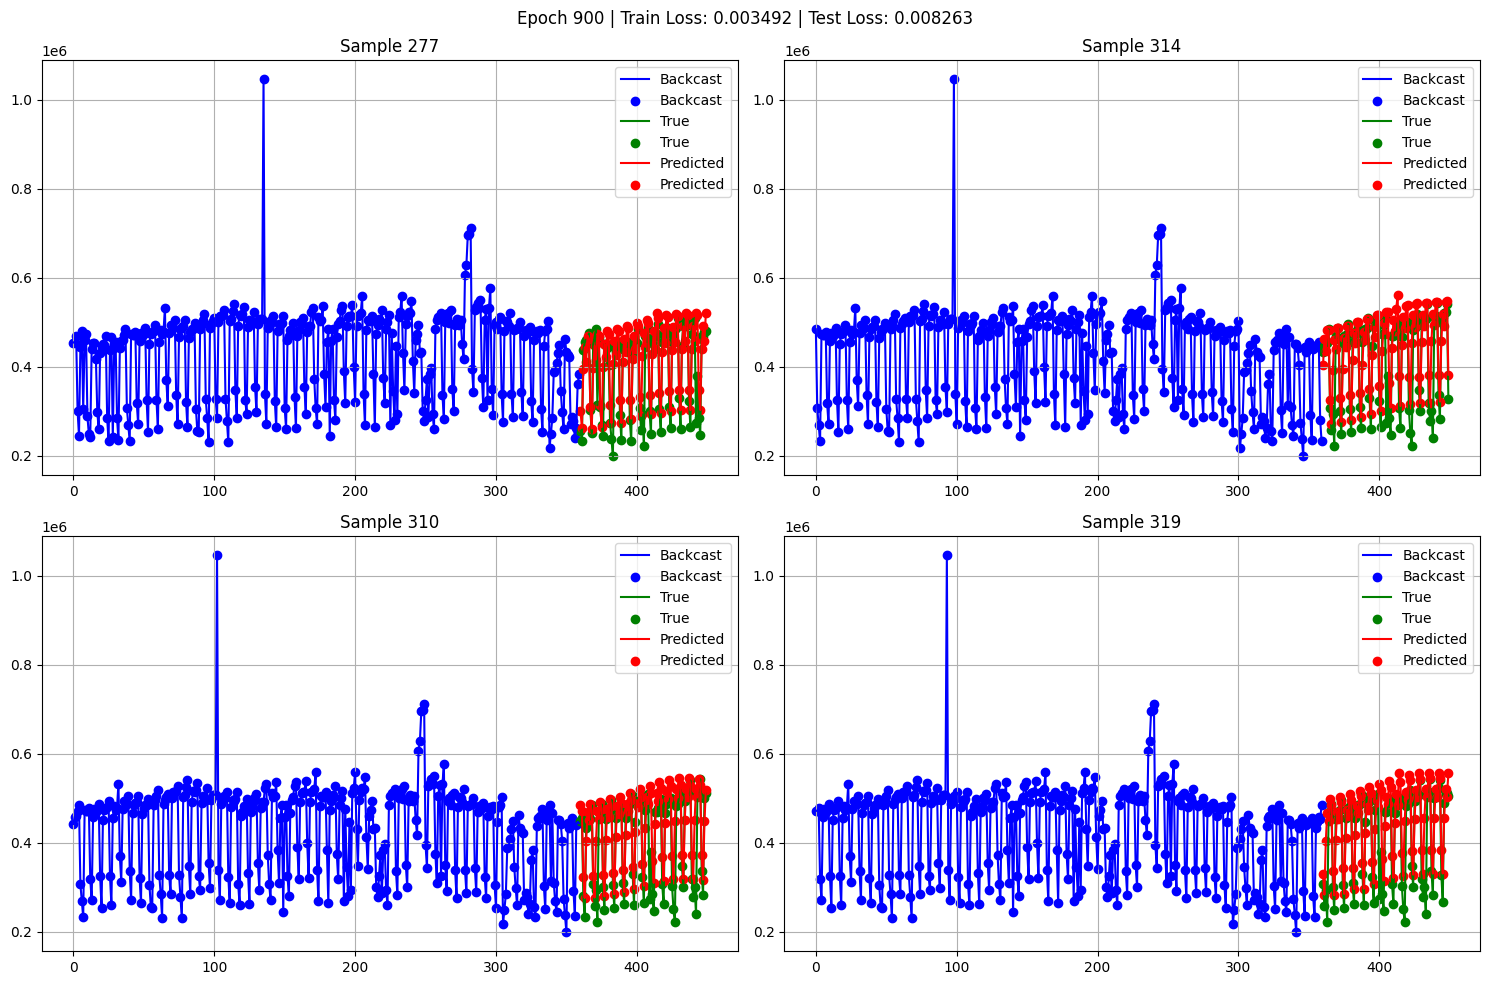

epoch = 0900, grad_step = 073882, train_loss = 3.492, test_loss = 8.263, best_test_loss = 7.874
Training completed!
Best test loss: 7.782
Training completed!
Best test loss: 7.782


In [14]:
def train():
    # ‡πÉ‡∏ä‡πâ global variables ‡πÅ‡∏ó‡∏ô‡∏Å‡∏≤‡∏£ redefine
    global forecast_length, backcast_length, batch_size, data
    
    
    # data backcast/forecast generation - ‡πÅ‡∏Å‡πâ‡πÑ‡∏Ç‡∏Å‡∏≤‡∏£‡πÉ‡∏ä‡πâ epoch ‡∏ã‡πâ‡∏≥
    x, y = [], []
    for i in range(backcast_length, len(data) - forecast_length):
        x.append(data[i - backcast_length:i])
        y.append(data[i:i + forecast_length])
    x = np.array(x)
    y = np.array(y)
    
    print(f"Generated {len(x)} samples")

    # split train/test - ‡πÅ‡∏Å‡πâ‡πÑ‡∏Ç‡∏Å‡∏≤‡∏£‡πÅ‡∏ö‡πà‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•
    c = int(len(x) * 0.8)
    x_train, y_train = x[:c], y[:c]
    x_test, y_test = x[c:], y[c:]
    
    print(f"Train samples: {len(x_train)}, Test samples: {len(x_test)}")

    # normalization
    norm_constant = np.max(x_train)
    x_train, y_train = x_train / norm_constant, y_train / norm_constant
    x_test, y_test = x_test / norm_constant, y_test / norm_constant
    
    print(f"Normalization constant: {norm_constant}")

    # model - ‡πÅ‡∏Å‡πâ‡πÑ‡∏Ç: ‡πÉ‡∏ä‡πâ 2 stacks ‡πÅ‡∏ó‡∏ô 3 ‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏´‡∏•‡∏µ‡∏Å‡πÄ‡∏•‡∏µ‡πà‡∏¢‡∏á IndexError
    net = NBeatsNet(
        stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
        forecast_length=forecast_length,
        backcast_length=backcast_length,
        hidden_layer_units=128,
        nb_blocks_per_stack=3  # ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏à‡∏≥‡∏ô‡∏ß‡∏ô blocks ‡∏ï‡πà‡∏≠ stack ‡πÅ‡∏ó‡∏ô
    )
    
    
    # ‡πÅ‡∏Å‡πâ‡πÑ‡∏Ç learning rate ‡πÅ‡∏•‡∏∞‡πÄ‡∏û‡∏¥‡πà‡∏° weight decay
    optimiser = optim.Adam(params=net.parameters(), lr=1e-4, weight_decay=1e-4)

    grad_step = 0
    best_test_loss = float('inf')
    
    for epoch in range(1000):
        # train
        net.train()
        train_loss = []
        
        for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
            grad_step += 1
            optimiser.zero_grad()
            _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(net.device))
            loss = F.huber_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device), delta=1.0)
            train_loss.append(loss.item())
            loss.backward()
            
            # Gradient clipping ‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏õ‡πâ‡∏≠‡∏á‡∏Å‡∏±‡∏ô exploding gradients
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            
            optimiser.step()
            
        train_loss = np.mean(train_loss)

        # test
        net.eval()
        with torch.no_grad():  # ‡πÄ‡∏û‡∏¥‡πà‡∏° no_grad ‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏õ‡∏£‡∏∞‡∏´‡∏¢‡∏±‡∏î memory
    
            _, forecast = net(torch.tensor(x_test, dtype=torch.float).to(net.device))
            test_loss = F.huber_loss(forecast, torch.tensor(y_test, dtype=torch.float) , delta = 1.0).item()
            p = forecast.detach().cpu().numpy()  # ‡∏¢‡πâ‡∏≤‡∏¢‡∏Å‡∏•‡∏±‡∏ö CPU
        
        # Save best model
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            save(net, f'best_model.pth')
            
        if epoch % 100 == 0:
            subplots = [221, 222, 223, 224]
            plt.figure(figsize=(15, 10))
            
            # ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏ß‡πà‡∏≤‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏û‡∏≠‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö visualization
            n_samples = min(4, len(x_test))
            indices = np.random.choice(range(len(x_test)), size=n_samples, replace=False)
            
            for plot_id, i in enumerate(indices):
                ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
                plt.subplot(subplots[plot_id])
                plt.grid()
                plot_scatter(range(0, backcast_length), xx, label='Backcast', color='blue')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, label='True', color='green')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, label='Predicted', color='red')
                plt.legend()
                plt.title(f'Sample {i}')
            
            plt.suptitle(f'Epoch {epoch} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}')
            plt.tight_layout()
            plt.show()

            # ‡πÅ‡∏Å‡πâ‡πÑ‡∏Ç‡∏Å‡∏≤‡∏£ save - ‡πÉ‡∏ä‡πâ model ‡πÄ‡∏ó‡πà‡∏≤‡∏ô‡∏±‡πâ‡∏ô
            save(net, f'model_epoch_{epoch}.pth')
            print(f'epoch = {str(epoch).zfill(4)}, '
                  f'grad_step = {str(grad_step).zfill(6)}, '
                  f'train_loss = {1000 * train_loss:.3f}, '
                  f'test_loss = {1000 * test_loss:.3f}, '
                  f'best_test_loss = {1000 * best_test_loss:.3f}')

    print("Training completed!")
    print(f"Best test loss: {1000 * best_test_loss:.3f}")

# ‡πÄ‡∏£‡∏µ‡∏¢‡∏Å‡πÉ‡∏ä‡πâ function
if __name__ == "__main__":
    train()

In [5]:
def load_model(model_path='best_model.pth'):
    """‡πÇ‡∏´‡∏•‡∏î‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏ó‡∏µ‡πà‡∏ù‡∏∂‡∏Å‡πÅ‡∏•‡πâ‡∏ß"""
    global forecast_length , backcast_length
    net = NBeatsNet(
        stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
        forecast_length= forecast_length,
        backcast_length= backcast_length,
        hidden_layer_units=128,
        nb_blocks_per_stack=3
    )
    
    # ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏ß‡πà‡∏≤‡πÑ‡∏ü‡∏•‡πå‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏°‡∏µ‡∏≠‡∏¢‡∏π‡πà‡∏´‡∏£‡∏∑‡∏≠‡πÑ‡∏°‡πà
    if os.path.exists(model_path):
        net.load_state_dict(torch.load(model_path, map_location='cpu'))
        net.eval()
        print(f"‡πÇ‡∏´‡∏•‡∏î‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏à‡∏≤‡∏Å {model_path} ‡πÄ‡∏£‡∏µ‡∏¢‡∏ö‡∏£‡πâ‡∏≠‡∏¢‡πÅ‡∏•‡πâ‡∏ß")
    else:
        print(f"‡πÑ‡∏°‡πà‡∏û‡∏ö‡πÑ‡∏ü‡∏•‡πå‡πÇ‡∏°‡πÄ‡∏î‡∏• {model_path}")
        return None
    
    return net

def load_normalization_constant():
    """‡πÇ‡∏´‡∏•‡∏î‡∏Ñ‡πà‡∏≤ normalization constant ‡∏à‡∏≤‡∏Å‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏ó‡∏£‡∏ô"""
    global data, backcast_length, forecast_length
    
    # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏ó‡∏£‡∏ô‡πÄ‡∏´‡∏°‡∏∑‡∏≠‡∏ô‡∏ï‡∏≠‡∏ô‡∏ù‡∏∂‡∏Å
    x_train_for_norm = []
    for i in range(backcast_length, len(data) - forecast_length):
        x_train_for_norm.append(data[i - backcast_length:i])
    x_train_for_norm = np.array(x_train_for_norm)
    
    # ‡πÅ‡∏ö‡πà‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏ó‡∏£‡∏ô (80%)
    c = int(len(x_train_for_norm) * 0.8)
    x_train_norm = x_train_for_norm[:c]
    
    norm_constant = np.max(x_train_norm)
    return norm_constant

def predict(model_path='best_model.pth', num_predictions=30, use_recent_data=True):
    """
    ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏≠‡∏ô‡∏≤‡∏Ñ‡∏ï
    
    Args:
        model_path: path ‡∏Ç‡∏≠‡∏á‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏ó‡∏µ‡πà‡∏ù‡∏∂‡∏Å‡πÅ‡∏•‡πâ‡∏ß
        num_predictions: ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
        use_recent_data: ‡πÉ‡∏ä‡πâ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏•‡πà‡∏≤‡∏™‡∏∏‡∏î‡πÄ‡∏õ‡πá‡∏ô input ‡∏´‡∏£‡∏∑‡∏≠‡πÑ‡∏°‡πà
    
    Returns:
        predictions: array ‡∏Ç‡∏≠‡∏á‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
    """
    # ‡πÇ‡∏´‡∏•‡∏î‡πÇ‡∏°‡πÄ‡∏î‡∏•‡πÅ‡∏•‡∏∞ normalization constant
    net = load_model(model_path)
    if net is None:
        return None
        
    norm_constant = load_normalization_constant()
    print(f"Normalization constant: {norm_constant}")
    
    # ‡πÄ‡∏ï‡∏£‡∏µ‡∏¢‡∏°‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• input
    if use_recent_data:
        # ‡πÉ‡∏ä‡πâ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• backcast_length ‡∏ß‡∏±‡∏ô‡∏•‡πà‡∏≤‡∏™‡∏∏‡∏î
        input_data = data[-backcast_length:].copy()
    else:
        # ‡πÉ‡∏ä‡πâ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏à‡∏≤‡∏Å‡∏ï‡∏≥‡πÅ‡∏´‡∏ô‡πà‡∏á‡∏ó‡∏µ‡πà‡∏Å‡∏≥‡∏´‡∏ô‡∏î
        input_data = data[-backcast_length-forecast_length:-forecast_length].copy()
    
    # Normalize ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• input
    input_normalized = input_data / norm_constant
    input_tensor = torch.tensor(input_normalized, dtype=torch.float).unsqueeze(0)  # ‡πÄ‡∏û‡∏¥‡πà‡∏° batch dimension
    
    predictions = []
    current_input = input_tensor.clone()
    
    with torch.no_grad():
        for i in range(num_predictions):
            # ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
            _, forecast = net(current_input)
            
            # ‡πÄ‡∏≠‡∏≤‡∏ú‡∏•‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏ß‡∏±‡∏ô‡πÅ‡∏£‡∏Å
            next_pred = forecast[0, 0].item()  # ‡πÄ‡∏≠‡∏≤‡∏ß‡∏±‡∏ô‡πÅ‡∏£‡∏Å‡∏à‡∏≤‡∏Å forecast
            predictions.append(next_pred * norm_constant)  # denormalize
            
            # ‡∏≠‡∏±‡∏û‡πÄ‡∏î‡∏ó input ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏Ñ‡∏£‡∏±‡πâ‡∏á‡∏ï‡πà‡∏≠‡πÑ‡∏õ
            # ‡πÄ‡∏•‡∏∑‡πà‡∏≠‡∏ô input ‡πÑ‡∏õ‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤ 1 ‡∏ß‡∏±‡∏ô ‡πÅ‡∏•‡∏∞‡πÉ‡∏™‡πà‡∏ú‡∏•‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡πÉ‡∏´‡∏°‡πà
            new_input = current_input[0, 1:].clone()  # ‡πÄ‡∏≠‡∏≤‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ï‡∏±‡πâ‡∏á‡πÅ‡∏ï‡πà‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà 2
            new_input = torch.cat([new_input, torch.tensor([next_pred])])  # ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏ú‡∏•‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡πÉ‡∏´‡∏°‡πà
            current_input = new_input.unsqueeze(0)
    
    return np.array(predictions)

def visualize_predictions(predictions, title="‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£‡∏£‡∏ñ‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡∏™‡∏≤‡∏¢‡∏™‡∏µ‡∏ô‡πâ‡∏≥‡πÄ‡∏á‡∏¥‡∏ô"):
    """
    ‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡πÉ‡∏ô‡∏Å‡∏£‡∏≤‡∏ü‡∏ó‡∏µ‡πà‡∏™‡∏ß‡∏¢‡∏á‡∏≤‡∏°‡∏û‡∏£‡πâ‡∏≠‡∏°‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà‡∏à‡∏£‡∏¥‡∏á
    """
    if predictions is None:
        print("‡πÑ‡∏°‡πà‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡πÑ‡∏î‡πâ‡πÄ‡∏ô‡∏∑‡πà‡∏≠‡∏á‡∏à‡∏≤‡∏Å‡πÑ‡∏°‡πà‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢")
        return
    
    # ‡∏ï‡∏±‡πâ‡∏á‡∏Ñ‡πà‡∏≤ matplotlib ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö font ‡∏†‡∏≤‡∏©‡∏≤‡πÑ‡∏ó‡∏¢
    import matplotlib
    matplotlib.rcParams['font.family'] = ['DejaVu Sans', 'Arial Unicode MS', 'Tahoma', 'Microsoft Sans Serif']
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['axes.unicode_minus'] = False
    
    # ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Å‡∏≤‡∏£‡∏ï‡∏±‡πâ‡∏á‡∏Ñ‡πà‡∏≤‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏£‡∏≠‡∏á‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡∏†‡∏≤‡∏©‡∏≤‡πÑ‡∏ó‡∏¢
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial Unicode MS', 'Tahoma', 'Microsoft Sans Serif']
    plt.rcParams['axes.unicode_minus'] = False
    
    # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü‡∏Ç‡∏ô‡∏≤‡∏î‡πÉ‡∏´‡∏ç‡πà
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))
    
    # ‡∏Å‡∏£‡∏≤‡∏ü‡∏´‡∏•‡∏±‡∏Å - ‡πÅ‡∏™‡∏î‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏à‡∏£‡∏¥‡∏á‡πÅ‡∏•‡∏∞‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
    historical_days = min(120, len(data))
    historical_data = data[-historical_days:]
    
    # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà‡∏à‡∏£‡∏¥‡∏á‡∏à‡∏≤‡∏Å‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•
    transport_dates = pd.to_datetime(transport_data['‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà'])
    last_date = transport_dates.iloc[-1]
    
    # ‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏à‡∏£‡∏¥‡∏á‡∏¢‡πâ‡∏≠‡∏ô‡∏´‡∏•‡∏±‡∏á
    historical_dates = pd.date_range(
        end=last_date, 
        periods=historical_days, 
        freq='D'
    )
    
    # ‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ (‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏à‡∏≤‡∏Å‡∏ß‡∏±‡∏ô‡∏ñ‡∏±‡∏î‡πÑ‡∏õ)
    prediction_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1),
        periods=len(predictions),
        freq='D'
    )
    
    # ‡∏û‡∏•‡πá‡∏≠‡∏ï‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏à‡∏£‡∏¥‡∏á
    ax1.plot(historical_dates, historical_data, 
             label='‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏à‡∏£‡∏¥‡∏á', color='#2E86AB', linewidth=2.5, alpha=0.8)
    
    # ‡∏û‡∏•‡πá‡∏≠‡∏ï‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
    ax1.plot(prediction_dates, predictions, 
             label='‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢', color='#F24236', linewidth=3, linestyle='-', alpha=0.9)
    
    # ‡πÄ‡∏™‡πâ‡∏ô‡πÅ‡∏ö‡πà‡∏á‡∏£‡∏∞‡∏´‡∏ß‡πà‡∏≤‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏à‡∏£‡∏¥‡∏á‡πÅ‡∏•‡∏∞‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
    ax1.axvline(x=last_date, color='#A23B72', linestyle='--', alpha=0.7, 
                linewidth=2, label='‡∏à‡∏∏‡∏î‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢')
    
    # ‡∏ï‡∏Å‡πÅ‡∏ï‡πà‡∏á‡∏Å‡∏£‡∏≤‡∏ù‡∏´‡∏•‡∏±‡∏Å
    ax1.set_xlabel('‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà', fontsize=14, fontweight='bold')
    ax1.set_ylabel('‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£ (‡∏Ñ‡∏ô)', fontsize=14, fontweight='bold')
    ax1.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax1.legend(fontsize=12, loc='upper left')
    ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # ‡∏õ‡∏£‡∏±‡∏ö‡πÅ‡∏ï‡πà‡∏á‡πÅ‡∏Å‡∏ô x
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', labelsize=10)
    
    # ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏û‡∏∑‡πâ‡∏ô‡∏´‡∏•‡∏±‡∏á‡∏™‡∏µ
    ax1.set_facecolor('#F8F9FA')
    
    # ‡∏à‡∏±‡∏î‡∏£‡∏π‡∏õ‡πÅ‡∏ö‡∏ö‡∏ï‡∏±‡∏ß‡πÄ‡∏•‡∏Ç‡πÅ‡∏Å‡∏ô y
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # ‡∏Å‡∏£‡∏≤‡∏ü‡∏¢‡πà‡∏≠‡∏¢ - ‡∏™‡∏ñ‡∏¥‡∏ï‡∏¥‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
    stats_data = {
        '‡∏Ñ‡πà‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢': np.mean(predictions),
        '‡∏Ñ‡πà‡∏≤‡∏™‡∏π‡∏á‡∏™‡∏∏‡∏î': np.max(predictions),
        '‡∏Ñ‡πà‡∏≤‡∏ï‡πà‡∏≥‡∏™‡∏∏‡∏î': np.min(predictions),
        '‡∏™‡πà‡∏ß‡∏ô‡πÄ‡∏ö‡∏µ‡πà‡∏¢‡∏á‡πÄ‡∏ö‡∏ô‡∏°‡∏≤‡∏ï‡∏£‡∏ê‡∏≤‡∏ô': np.std(predictions)
    }
    
    colors = ['#2E86AB', '#A23B72', '#F24236', '#F18F01']
    bars = ax2.bar(stats_data.keys(), stats_data.values(), color=colors, alpha=0.8)
    
    # ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ñ‡πà‡∏≤‡∏ö‡∏ô‡πÅ‡∏ó‡πà‡∏á‡∏Å‡∏£‡∏≤‡∏ü
    for bar, value in zip(bars, stats_data.values()):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(stats_data.values())*0.01,
                f'{value:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax2.set_title('‡∏™‡∏ñ‡∏¥‡∏ï‡∏¥‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢', fontsize=14, fontweight='bold', pad=15)
    ax2.set_ylabel('‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£ (‡∏Ñ‡∏ô)', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='x', rotation=0, labelsize=11)
    ax2.tick_params(axis='y', labelsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_facecolor('#F8F9FA')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # ‡∏õ‡∏£‡∏±‡∏ö layout
    plt.tight_layout(pad=3.0)
    
    # ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏™‡∏£‡∏∏‡∏õ
    textstr = f'''‡∏™‡∏£‡∏∏‡∏õ‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢:
‚Ä¢ ‡∏£‡∏∞‡∏¢‡∏∞‡πÄ‡∏ß‡∏•‡∏≤: {len(predictions)} ‡∏ß‡∏±‡∏ô
‚Ä¢ ‡∏à‡∏≤‡∏Å‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà: {prediction_dates[0].strftime('%d/%m/%Y')}
‚Ä¢ ‡∏ñ‡∏∂‡∏á‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà: {prediction_dates[-1].strftime('%d/%m/%Y')}
‚Ä¢ ‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢: {np.mean(predictions):,.0f} ‡∏Ñ‡∏ô/‡∏ß‡∏±‡∏ô
‚Ä¢ ‡πÅ‡∏ô‡∏ß‡πÇ‡∏ô‡πâ‡∏°: {"‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡∏∂‡πâ‡∏ô" if predictions[-1] > predictions[0] else "‡∏•‡∏î‡∏•‡∏á" if predictions[-1] < predictions[0] else "‡∏Ñ‡∏á‡∏ó‡∏µ‡πà"}'''
    
    # ‡πÄ‡∏û‡∏¥‡πà‡∏° text box
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    fig.text(0.02, 0.02, textstr, fontsize=10, verticalalignment='bottom', bbox=props)
    
    plt.show()
    
    # ‡πÅ‡∏™‡∏î‡∏á‡∏™‡∏ñ‡∏¥‡∏ï‡∏¥‡∏£‡∏≤‡∏¢‡∏•‡∏∞‡πÄ‡∏≠‡∏µ‡∏¢‡∏î
    print("=" * 60)
    print("üìä ‡∏™‡∏ñ‡∏¥‡∏ï‡∏¥‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£‡∏£‡∏ñ‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡∏™‡∏≤‡∏¢‡∏™‡∏µ‡∏ô‡πâ‡∏≥‡πÄ‡∏á‡∏¥‡∏ô")
    print("=" * 60)
    print(f"üóìÔ∏è  ‡∏£‡∏∞‡∏¢‡∏∞‡πÄ‡∏ß‡∏•‡∏≤‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢: {len(predictions)} ‡∏ß‡∏±‡∏ô")
    print(f"üìÖ ‡∏ß‡∏±‡∏ô‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏ï‡πâ‡∏ô: {prediction_dates[0].strftime('%d %B %Y')}")
    print(f"üìÖ ‡∏ß‡∏±‡∏ô‡∏™‡∏¥‡πâ‡∏ô‡∏™‡∏∏‡∏î: {prediction_dates[-1].strftime('%d %B %Y')}")
    print(f"üë• ‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢: {np.mean(predictions):,.0f} ‡∏Ñ‡∏ô/‡∏ß‡∏±‡∏ô")
    print(f"üìà ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏™‡∏π‡∏á‡∏™‡∏∏‡∏î: {np.max(predictions):,.0f} ‡∏Ñ‡∏ô (‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà {prediction_dates[np.argmax(predictions)].strftime('%d/%m/%Y')})")
    print(f"üìâ ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏ï‡πà‡∏≥‡∏™‡∏∏‡∏î: {np.min(predictions):,.0f} ‡∏Ñ‡∏ô (‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà {prediction_dates[np.argmin(predictions)].strftime('%d/%m/%Y')})")
    print(f"üìä ‡∏™‡πà‡∏ß‡∏ô‡πÄ‡∏ö‡∏µ‡πà‡∏¢‡∏á‡πÄ‡∏ö‡∏ô‡∏°‡∏≤‡∏ï‡∏£‡∏ê‡∏≤‡∏ô: {np.std(predictions):,.0f}")
    print(f"üìã ‡∏ú‡∏•‡∏£‡∏ß‡∏°‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î: {np.sum(predictions):,.0f} ‡∏Ñ‡∏ô")
    print("=" * 60)

def save_predictions_to_csv(predictions, filename="predictions.csv"):
    """
    ‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏•‡∏á‡πÑ‡∏ü‡∏•‡πå CSV
    """
    if predictions is None:
        print("‡πÑ‡∏°‡πà‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡πÑ‡∏î‡πâ‡πÄ‡∏ô‡∏∑‡πà‡∏≠‡∏á‡∏à‡∏≤‡∏Å‡πÑ‡∏°‡πà‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢")
        return
    
    # ‡∏™‡∏£‡πâ‡∏≤‡∏á DataFrame
    df = pd.DataFrame({
        '‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà': range(1, len(predictions) + 1),
        '‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£_‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢': predictions.astype(int)
    })
    
    # ‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏•‡∏á‡πÑ‡∏ü‡∏•‡πå
    df.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏•‡∏á‡πÑ‡∏ü‡∏•‡πå {filename} ‡πÄ‡∏£‡∏µ‡∏¢‡∏ö‡∏£‡πâ‡∏≠‡∏¢‡πÅ‡∏•‡πâ‡∏ß")
    print(f"‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÅ‡∏ñ‡∏ß: {len(df)}")

def run_prediction_demo():
    """
    ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏£‡∏±‡∏ô‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡πÅ‡∏ö‡∏ö‡∏™‡∏≤‡∏ò‡∏¥‡∏ï
    """
    print("=== ‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏î‡πâ‡∏ß‡∏¢‡πÇ‡∏°‡πÄ‡∏î‡∏• N-BEATS ===")
    
    # ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 30 ‡∏ß‡∏±‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤
    predictions = predict(num_predictions=30)
    
    if predictions is not None:
        # ‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡∏Å‡∏£‡∏≤‡∏ü
        visualize_predictions(predictions)
        
        # ‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏•‡∏á‡πÑ‡∏ü‡∏•‡πå
        save_predictions_to_csv(predictions)
        
        print("\n‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡πÄ‡∏™‡∏£‡πá‡∏à‡∏™‡∏°‡∏ö‡∏π‡∏£‡∏ì‡πå!")
    else:
        print("‡πÄ‡∏Å‡∏¥‡∏î‡∏Ç‡πâ‡∏≠‡∏ú‡∏¥‡∏î‡∏û‡∏•‡∏≤‡∏î‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢")


transport_data = pd.read_csv('../../data/data_adjustmented.csv', parse_dates=['‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà'])
data = transport_data['‡∏£‡∏ñ‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡∏™‡∏≤‡∏¢‡∏™‡∏µ‡∏ô‡πâ‡∏≥‡πÄ‡∏á‡∏¥‡∏ô'].values.flatten()  # Use .flatten() to convert to 1D
forecast_length = 90
backcast_length = 4 * forecast_length
# ‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏Å‡∏≤‡∏£‡πÉ‡∏ä‡πâ‡∏á‡∏≤‡∏ô (‡∏¢‡∏Å‡πÄ‡∏•‡∏¥‡∏Å‡∏Ñ‡∏≠‡∏°‡πÄ‡∏°‡∏ô‡∏ï‡πå‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏£‡∏±‡∏ô)
predictions = predict(num_predictions=90)
visualize_predictions(predictions)
# save_predictions_to_csv(predictions)

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205113184
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @2233453772096
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205868336
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205867904
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205867424
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205867040
‡πÑ‡∏°‡πà‡∏û‡∏ö‡πÑ‡∏ü‡∏•‡πå‡πÇ‡∏°‡πÄ‡∏î‡∏• best_model.pth
‡πÑ‡∏°‡πà‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡πÑ‡∏î‡πâ‡πÄ‡

In [6]:
def analyze_daily_patterns(predictions):
    """
    ‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå‡∏£‡∏π‡∏õ‡πÅ‡∏ö‡∏ö‡∏Å‡∏≤‡∏£‡πÉ‡∏ä‡πâ‡∏á‡∏≤‡∏ô‡∏£‡∏≤‡∏¢‡∏ß‡∏±‡∏ô
    """
    transport_dates = pd.to_datetime(transport_data['‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà'])
    last_date = transport_dates.iloc[-1]
    
    # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
    prediction_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1),
        periods=len(predictions),
        freq='D'
    )
    
    # ‡∏™‡∏£‡πâ‡∏≤‡∏á DataFrame ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå
    df_pred = pd.DataFrame({
        '‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà': prediction_dates,
        '‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£': predictions,
        '‡∏ß‡∏±‡∏ô‡πÉ‡∏ô‡∏™‡∏±‡∏õ‡∏î‡∏≤‡∏´‡πå': prediction_dates.day_name(),
        '‡πÄ‡∏î‡∏∑‡∏≠‡∏ô': prediction_dates.month_name(),
        '‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà‡πÉ‡∏ô‡πÄ‡∏î‡∏∑‡∏≠‡∏ô': prediction_dates.day
    })
    
    # ‡∏ï‡∏±‡πâ‡∏á‡∏Ñ‡πà‡∏≤ font
    import matplotlib
    matplotlib.rcParams['font.family'] = ['DejaVu Sans', 'Arial Unicode MS', 'Tahoma', 'Microsoft Sans Serif']
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['axes.unicode_minus'] = False
    
    # ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Å‡∏≤‡∏£‡∏ï‡∏±‡πâ‡∏á‡∏Ñ‡πà‡∏≤‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏£‡∏≠‡∏á‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡∏†‡∏≤‡∏©‡∏≤‡πÑ‡∏ó‡∏¢
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial Unicode MS', 'Tahoma', 'Microsoft Sans Serif']
    plt.rcParams['axes.unicode_minus'] = False
    
    # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü 4 ‡πÅ‡∏ú‡∏á
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 14))
    
    # ‡∏Å‡∏£‡∏≤‡∏ü 1: ‡∏Å‡∏≤‡∏£‡πÉ‡∏ä‡πâ‡∏á‡∏≤‡∏ô‡∏ï‡∏≤‡∏°‡∏ß‡∏±‡∏ô‡πÉ‡∏ô‡∏™‡∏±‡∏õ‡∏î‡∏≤‡∏´‡πå
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_names_thai = ['‡∏à‡∏±‡∏ô‡∏ó‡∏£‡πå', '‡∏≠‡∏±‡∏á‡∏Ñ‡∏≤‡∏£', '‡∏û‡∏∏‡∏ò', '‡∏û‡∏§‡∏´‡∏±‡∏™‡∏ö‡∏î‡∏µ', '‡∏®‡∏∏‡∏Å‡∏£‡πå', '‡πÄ‡∏™‡∏≤‡∏£‡πå', '‡∏≠‡∏≤‡∏ó‡∏¥‡∏ï‡∏¢‡πå']
    
    daily_avg = df_pred.groupby('‡∏ß‡∏±‡∏ô‡πÉ‡∏ô‡∏™‡∏±‡∏õ‡∏î‡∏≤‡∏´‡πå')['‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£'].mean().reindex(day_order)
    colors1 = plt.cm.Set3(np.linspace(0, 1, 7))
    
    bars1 = ax1.bar(day_names_thai, daily_avg.values, color=colors1, alpha=0.8)
    for bar, value in zip(bars1, daily_avg.values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(daily_avg.values)*0.01,
                f'{value:,.0f}', ha='center', va='bottom', fontweight='bold')
    
    ax1.set_title('‡∏Ñ‡πà‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£‡∏ï‡∏≤‡∏°‡∏ß‡∏±‡∏ô‡πÉ‡∏ô‡∏™‡∏±‡∏õ‡∏î‡∏≤‡∏´‡πå', fontsize=14, fontweight='bold')
    ax1.set_ylabel('‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£ (‡∏Ñ‡∏ô)', fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # ‡∏Å‡∏£‡∏≤‡∏ü 2: ‡πÅ‡∏ô‡∏ß‡πÇ‡∏ô‡πâ‡∏°‡∏£‡∏≤‡∏¢‡∏™‡∏±‡∏õ‡∏î‡∏≤‡∏´‡πå
    df_pred['‡∏™‡∏±‡∏õ‡∏î‡∏≤‡∏´‡πå'] = df_pred['‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà'].dt.isocalendar().week
    weekly_avg = df_pred.groupby('‡∏™‡∏±‡∏õ‡∏î‡∏≤‡∏´‡πå')['‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£'].mean()
    
    ax2.plot(weekly_avg.index, weekly_avg.values, marker='o', linewidth=3, 
             markersize=8, color='#2E86AB', alpha=0.8)
    ax2.fill_between(weekly_avg.index, weekly_avg.values, alpha=0.3, color='#2E86AB')
    
    ax2.set_title('‡πÅ‡∏ô‡∏ß‡πÇ‡∏ô‡πâ‡∏°‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£‡∏£‡∏≤‡∏¢‡∏™‡∏±‡∏õ‡∏î‡∏≤‡∏´‡πå', fontsize=14, fontweight='bold')
    ax2.set_xlabel('‡∏™‡∏±‡∏õ‡∏î‡∏≤‡∏´‡πå‡∏ó‡∏µ‡πà', fontweight='bold')
    ax2.set_ylabel('‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢ (‡∏Ñ‡∏ô)', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # ‡∏Å‡∏£‡∏≤‡∏ü 3: ‡∏Å‡∏≤‡∏£‡∏Å‡∏£‡∏∞‡∏à‡∏≤‡∏¢‡∏ï‡∏±‡∏ß‡∏Ç‡∏≠‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•
    ax3.hist(predictions, bins=20, color='#F24236', alpha=0.7, edgecolor='black')
    ax3.axvline(np.mean(predictions), color='red', linestyle='--', linewidth=2, 
                label=f'‡∏Ñ‡πà‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢: {np.mean(predictions):,.0f}')
    ax3.axvline(np.median(predictions), color='green', linestyle='--', linewidth=2,
                label=f'‡∏Ñ‡πà‡∏≤‡∏Å‡∏•‡∏≤‡∏á: {np.median(predictions):,.0f}')
    
    ax3.set_title('‡∏Å‡∏≤‡∏£‡∏Å‡∏£‡∏∞‡∏à‡∏≤‡∏¢‡∏ï‡∏±‡∏ß‡∏Ç‡∏≠‡∏á‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£', fontsize=14, fontweight='bold')
    ax3.set_xlabel('‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£ (‡∏Ñ‡∏ô)', fontweight='bold')
    ax3.set_ylabel('‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ñ‡∏µ‡πà', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # ‡∏Å‡∏£‡∏≤‡∏ü 4: ‡∏õ‡∏è‡∏¥‡∏ó‡∏¥‡∏ô‡∏Ñ‡∏ß‡∏≤‡∏°‡∏£‡πâ‡∏≠‡∏ô (Heatmap)
    if len(predictions) >= 28:  # ‡∏ï‡πâ‡∏≠‡∏á‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏ô‡πâ‡∏≠‡∏¢ 4 ‡∏™‡∏±‡∏õ‡∏î‡∏≤‡∏´‡πå
        # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö heatmap
        df_pred['‡∏ß‡∏±‡∏ô‡πÉ‡∏ô‡∏™‡∏±‡∏õ‡∏î‡∏≤‡∏´‡πå_num'] = df_pred['‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà'].dt.dayofweek
        df_pred['‡∏™‡∏±‡∏õ‡∏î‡∏≤‡∏´‡πå_from_start'] = (df_pred['‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà'] - df_pred['‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà'].min()).dt.days // 7
        
        pivot_data = df_pred.pivot(index='‡∏™‡∏±‡∏õ‡∏î‡∏≤‡∏´‡πå_from_start', 
                                   columns='‡∏ß‡∏±‡∏ô‡πÉ‡∏ô‡∏™‡∏±‡∏õ‡∏î‡∏≤‡∏´‡πå_num', 
                                   values='‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£')
        
        im = ax4.imshow(pivot_data.values, cmap='YlOrRd', aspect='auto')
        ax4.set_xticks(range(7))
        ax4.set_xticklabels(['‡∏à', '‡∏≠', '‡∏û', '‡∏û‡∏§', '‡∏®', '‡∏™', '‡∏≠‡∏≤'])
        ax4.set_ylabel('‡∏™‡∏±‡∏õ‡∏î‡∏≤‡∏´‡πå‡∏ó‡∏µ‡πà', fontweight='bold')
        ax4.set_title('‡∏õ‡∏è‡∏¥‡∏ó‡∏¥‡∏ô‡∏Ñ‡∏ß‡∏≤‡∏°‡∏£‡πâ‡∏≠‡∏ô - ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£', fontsize=14, fontweight='bold')
        
        # ‡πÄ‡∏û‡∏¥‡πà‡∏° colorbar
        cbar = plt.colorbar(im, ax=ax4)
        cbar.set_label('‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£', rotation=270, labelpad=20, fontweight='bold')
    else:
        ax4.text(0.5, 0.5, '‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÑ‡∏°‡πà‡πÄ‡∏û‡∏µ‡∏¢‡∏á‡∏û‡∏≠‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö\n‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏õ‡∏è‡∏¥‡∏ó‡∏¥‡∏ô‡∏Ñ‡∏ß‡∏≤‡∏°‡∏£‡πâ‡∏≠‡∏ô\n(‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏ô‡πâ‡∏≠‡∏¢ 28 ‡∏ß‡∏±‡∏ô)', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('‡∏õ‡∏è‡∏¥‡∏ó‡∏¥‡∏ô‡∏Ñ‡∏ß‡∏≤‡∏°‡∏£‡πâ‡∏≠‡∏ô', fontsize=14, fontweight='bold')
    
    plt.tight_layout(pad=3.0)
    plt.show()
    
    return df_pred

def create_prediction_report(predictions, filename="prediction_report.csv"):
    """
    ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏£‡∏≤‡∏¢‡∏á‡∏≤‡∏ô‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏ó‡∏µ‡πà‡∏•‡∏∞‡πÄ‡∏≠‡∏µ‡∏¢‡∏î
    """
    df_analysis = analyze_daily_patterns(predictions)
    
    # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏£‡∏≤‡∏¢‡∏á‡∏≤‡∏ô‡∏™‡∏£‡∏∏‡∏õ
    report = {
        '‡∏™‡∏ñ‡∏¥‡∏ï‡∏¥‡∏ó‡∏±‡πà‡∏ß‡πÑ‡∏õ': {
            '‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢': len(predictions),
            '‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢': f"{np.mean(predictions):,.0f} ‡∏Ñ‡∏ô",
            '‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£‡∏™‡∏π‡∏á‡∏™‡∏∏‡∏î': f"{np.max(predictions):,.0f} ‡∏Ñ‡∏ô",
            '‡∏ú‡∏π‡πâ‡πÇ‡∏î‡∏¢‡∏™‡∏≤‡∏£‡∏ï‡πà‡∏≥‡∏™‡∏∏‡∏î': f"{np.min(predictions):,.0f} ‡∏Ñ‡∏ô",
            '‡∏™‡πà‡∏ß‡∏ô‡πÄ‡∏ö‡∏µ‡πà‡∏¢‡∏á‡πÄ‡∏ö‡∏ô‡∏°‡∏≤‡∏ï‡∏£‡∏ê‡∏≤‡∏ô': f"{np.std(predictions):,.0f}",
            '‡∏ú‡∏•‡∏£‡∏ß‡∏°‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î': f"{np.sum(predictions):,.0f} ‡∏Ñ‡∏ô"
        }
    }
    
    # ‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÇ‡∏î‡∏¢‡∏•‡∏∞‡πÄ‡∏≠‡∏µ‡∏¢‡∏î
    df_analysis.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"üìÑ ‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏£‡∏≤‡∏¢‡∏á‡∏≤‡∏ô‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏•‡∏á‡πÑ‡∏ü‡∏•‡πå {filename} ‡πÄ‡∏£‡∏µ‡∏¢‡∏ö‡∏£‡πâ‡∏≠‡∏¢‡πÅ‡∏•‡πâ‡∏ß")
    
    return report

# ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô‡∏Å‡∏≤‡∏£‡∏£‡∏±‡∏ô‡πÅ‡∏ö‡∏ö‡∏Ñ‡∏£‡∏ö‡∏Ñ‡∏£‡∏±‡∏ô
def run_complete_analysis():
    """
    ‡∏£‡∏±‡∏ô‡∏Å‡∏≤‡∏£‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå‡πÅ‡∏ö‡∏ö‡∏Ñ‡∏£‡∏ö‡∏Ñ‡∏£‡∏±‡∏ô
    """
    print("üöÄ ‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏Å‡∏≤‡∏£‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå‡πÅ‡∏ö‡∏ö‡∏Ñ‡∏£‡∏ö‡∏Ñ‡∏£‡∏±‡∏ô...")
    
    # ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
    predictions = predict(num_predictions=90)
    
    if predictions is not None:
        # ‡πÅ‡∏™‡∏î‡∏á‡∏Å‡∏£‡∏≤‡∏ü‡∏´‡∏•‡∏±‡∏Å
        visualize_predictions(predictions)
        
        # ‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå‡∏£‡∏π‡∏õ‡πÅ‡∏ö‡∏ö
        df_analysis = analyze_daily_patterns(predictions)
        
        # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏£‡∏≤‡∏¢‡∏á‡∏≤‡∏ô
        report = create_prediction_report(predictions, "blue_line_prediction_report.csv")
        
        print("‚úÖ ‡∏Å‡∏≤‡∏£‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå‡πÄ‡∏™‡∏£‡πá‡∏à‡∏™‡∏°‡∏ö‡∏π‡∏£‡∏ì‡πå!")
        return predictions, df_analysis, report
    else:
        print("‚ùå ‡πÄ‡∏Å‡∏¥‡∏î‡∏Ç‡πâ‡∏≠‡∏ú‡∏¥‡∏î‡∏û‡∏•‡∏≤‡∏î‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢")
        return None, None, None

In [7]:
# ‡∏ó‡∏î‡∏™‡∏≠‡∏ö‡∏Å‡∏≤‡∏£‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå‡πÅ‡∏ö‡∏ö‡∏Ñ‡∏£‡∏ö‡∏Ñ‡∏£‡∏±‡∏ô
predictions, df_analysis, report = run_complete_analysis()

üöÄ ‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏Å‡∏≤‡∏£‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå‡πÅ‡∏ö‡∏ö‡∏Ñ‡∏£‡∏ö‡∏Ñ‡∏£‡∏±‡∏ô...
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205866848
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205866992
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205871360
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205371472
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205371760
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205371520
‡πÑ‡∏°‡πà‡∏û‡∏ö‡πÑ‡∏ü‡∏•‡π

In [8]:
def visualize_predictions_en(predictions, title="Blue Line BTS Ridership Prediction"):
    """
    ‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡πÉ‡∏ô‡∏Å‡∏£‡∏≤‡∏ü (‡∏†‡∏≤‡∏©‡∏≤‡∏≠‡∏±‡∏á‡∏Å‡∏§‡∏©)
    """
    if predictions is None:
        print("Cannot display chart - no prediction data available")
        return
    
    # ‡∏ï‡∏±‡πâ‡∏á‡∏Ñ‡πà‡∏≤ matplotlib
    import matplotlib
    matplotlib.rcParams['font.family'] = ['DejaVu Sans', 'Arial', 'sans-serif']
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['axes.unicode_minus'] = False
    
    # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü‡∏Ç‡∏ô‡∏≤‡∏î‡πÉ‡∏´‡∏ç‡πà
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))
    
    # ‡∏Å‡∏£‡∏≤‡∏ü‡∏´‡∏•‡∏±‡∏Å - ‡πÅ‡∏™‡∏î‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏à‡∏£‡∏¥‡∏á‡πÅ‡∏•‡∏∞‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
    historical_days = min(120, len(data))
    historical_data = data[-historical_days:]
    
    # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà‡∏à‡∏£‡∏¥‡∏á‡∏à‡∏≤‡∏Å‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•
    transport_dates = pd.to_datetime(transport_data['‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà'])
    last_date = transport_dates.iloc[-1]
    
    # ‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏à‡∏£‡∏¥‡∏á‡∏¢‡πâ‡∏≠‡∏ô‡∏´‡∏•‡∏±‡∏á
    historical_dates = pd.date_range(
        end=last_date, 
        periods=historical_days, 
        freq='D'
    )
    
    # ‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ (‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏à‡∏≤‡∏Å‡∏ß‡∏±‡∏ô‡∏ñ‡∏±‡∏î‡πÑ‡∏õ)
    prediction_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1),
        periods=len(predictions),
        freq='D'
    )
    
    # ‡∏û‡∏•‡πá‡∏≠‡∏ï‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏à‡∏£‡∏¥‡∏á
    ax1.plot(historical_dates, historical_data, 
             label='Historical Data', color='#2E86AB', linewidth=2.5, alpha=0.8)
    
    # ‡∏û‡∏•‡πá‡∏≠‡∏ï‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
    ax1.plot(prediction_dates, predictions, 
             label='Predictions', color='#F24236', linewidth=3, linestyle='-', alpha=0.9)
    
    # ‡πÄ‡∏™‡πâ‡∏ô‡πÅ‡∏ö‡πà‡∏á‡∏£‡∏∞‡∏´‡∏ß‡πà‡∏≤‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏à‡∏£‡∏¥‡∏á‡πÅ‡∏•‡∏∞‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
    ax1.axvline(x=last_date, color='#A23B72', linestyle='--', alpha=0.7, 
                linewidth=2, label='Prediction Start')
    
    # ‡∏ï‡∏Å‡πÅ‡∏ï‡πà‡∏á‡∏Å‡∏£‡∏≤‡∏ü‡∏´‡∏•‡∏±‡∏Å
    ax1.set_xlabel('Date', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Passengers', fontsize=14, fontweight='bold')
    ax1.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax1.legend(fontsize=12, loc='upper left')
    ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # ‡∏õ‡∏£‡∏±‡∏ö‡πÅ‡∏ï‡πà‡∏á‡πÅ‡∏Å‡∏ô x
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', labelsize=10)
    
    # ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏û‡∏∑‡πâ‡∏ô‡∏´‡∏•‡∏±‡∏á‡∏™‡∏µ
    ax1.set_facecolor('#F8F9FA')
    
    # ‡∏à‡∏±‡∏î‡∏£‡∏π‡∏õ‡πÅ‡∏ö‡∏ö‡∏ï‡∏±‡∏ß‡πÄ‡∏•‡∏Ç‡πÅ‡∏Å‡∏ô y
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # ‡∏Å‡∏£‡∏≤‡∏ü‡∏¢‡πà‡∏≠‡∏¢ - ‡∏™‡∏ñ‡∏¥‡∏ï‡∏¥‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
    stats_data = {
        'Mean': np.mean(predictions),
        'Max': np.max(predictions),
        'Min': np.min(predictions),
        'Std Dev': np.std(predictions)
    }
    
    colors = ['#2E86AB', '#A23B72', '#F24236', '#F18F01']
    bars = ax2.bar(stats_data.keys(), stats_data.values(), color=colors, alpha=0.8)
    
    # ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ñ‡πà‡∏≤‡∏ö‡∏ô‡πÅ‡∏ó‡πà‡∏á‡∏Å‡∏£‡∏≤‡∏ü
    for bar, value in zip(bars, stats_data.values()):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(stats_data.values())*0.01,
                f'{value:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax2.set_title('Prediction Statistics', fontsize=14, fontweight='bold', pad=15)
    ax2.set_ylabel('Number of Passengers', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='x', rotation=0, labelsize=11)
    ax2.tick_params(axis='y', labelsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_facecolor('#F8F9FA')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # ‡∏õ‡∏£‡∏±‡∏ö layout
    plt.tight_layout(pad=3.0)
    
    # ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏™‡∏£‡∏∏‡∏õ
    trend = "Increasing" if predictions[-1] > predictions[0] else "Decreasing" if predictions[-1] < predictions[0] else "Stable"
    textstr = f'''Prediction Summary:
‚Ä¢ Duration: {len(predictions)} days
‚Ä¢ From: {prediction_dates[0].strftime('%d/%m/%Y')}
‚Ä¢ To: {prediction_dates[-1].strftime('%d/%m/%Y')}
‚Ä¢ Avg Passengers: {np.mean(predictions):,.0f} per day
‚Ä¢ Trend: {trend}'''
    
    # ‡πÄ‡∏û‡∏¥‡πà‡∏° text box
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    fig.text(0.02, 0.02, textstr, fontsize=10, verticalalignment='bottom', bbox=props)
    
    plt.show()
    
    # ‡πÅ‡∏™‡∏î‡∏á‡∏™‡∏ñ‡∏¥‡∏ï‡∏¥‡∏£‡∏≤‡∏¢‡∏•‡∏∞‡πÄ‡∏≠‡∏µ‡∏¢‡∏î
    print("=" * 60)
    print("üìä BTS Blue Line Ridership Prediction Statistics")
    print("=" * 60)
    print(f"üóìÔ∏è  Prediction Period: {len(predictions)} days")
    print(f"üìÖ Start Date: {prediction_dates[0].strftime('%d %B %Y')}")
    print(f"üìÖ End Date: {prediction_dates[-1].strftime('%d %B %Y')}")
    print(f"üë• Average Passengers: {np.mean(predictions):,.0f} per day")
    print(f"üìà Maximum: {np.max(predictions):,.0f} on {prediction_dates[np.argmax(predictions)].strftime('%d/%m/%Y')}")
    print(f"üìâ Minimum: {np.min(predictions):,.0f} on {prediction_dates[np.argmin(predictions)].strftime('%d/%m/%Y')}")
    print(f"üìä Standard Deviation: {np.std(predictions):,.0f}")
    print(f"üìã Total Passengers: {np.sum(predictions):,.0f}")
    print("=" * 60)

def analyze_daily_patterns_en(predictions):
    """
    ‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå‡∏£‡∏π‡∏õ‡πÅ‡∏ö‡∏ö‡∏Å‡∏≤‡∏£‡πÉ‡∏ä‡πâ‡∏á‡∏≤‡∏ô‡∏£‡∏≤‡∏¢‡∏ß‡∏±‡∏ô (‡∏†‡∏≤‡∏©‡∏≤‡∏≠‡∏±‡∏á‡∏Å‡∏§‡∏©)
    """
    transport_dates = pd.to_datetime(transport_data['‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà'])
    last_date = transport_dates.iloc[-1]
    
    # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
    prediction_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1),
        periods=len(predictions),
        freq='D'
    )
    
    # ‡∏™‡∏£‡πâ‡∏≤‡∏á DataFrame ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå
    df_pred = pd.DataFrame({
        'Date': prediction_dates,
        'Passengers': predictions,
        'DayOfWeek': prediction_dates.day_name(),
        'Month': prediction_dates.month_name(),
        'Day': prediction_dates.day
    })
    
    # ‡∏ï‡∏±‡πâ‡∏á‡∏Ñ‡πà‡∏≤ font
    import matplotlib
    matplotlib.rcParams['font.family'] = ['DejaVu Sans', 'Arial', 'sans-serif']
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['axes.unicode_minus'] = False
    
    # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü 4 ‡πÅ‡∏ú‡∏á
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 14))
    
    # ‡∏Å‡∏£‡∏≤‡∏ü 1: ‡∏Å‡∏≤‡∏£‡πÉ‡∏ä‡πâ‡∏á‡∏≤‡∏ô‡∏ï‡∏≤‡∏°‡∏ß‡∏±‡∏ô‡πÉ‡∏ô‡∏™‡∏±‡∏õ‡∏î‡∏≤‡∏´‡πå
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    daily_avg = df_pred.groupby('DayOfWeek')['Passengers'].mean().reindex(day_order)
    colors1 = plt.cm.Set3(np.linspace(0, 1, 7))
    
    bars1 = ax1.bar(day_order, daily_avg.values, color=colors1, alpha=0.8)
    for bar, value in zip(bars1, daily_avg.values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(daily_avg.values)*0.01,
                f'{value:,.0f}', ha='center', va='bottom', fontweight='bold')
    
    ax1.set_title('Average Passengers by Day of Week', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Passengers', fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # ‡∏Å‡∏£‡∏≤‡∏ü 2: ‡πÅ‡∏ô‡∏ß‡πÇ‡∏ô‡πâ‡∏°‡∏£‡∏≤‡∏¢‡∏™‡∏±‡∏õ‡∏î‡∏≤‡∏´‡πå
    df_pred['Week'] = df_pred['Date'].dt.isocalendar().week
    weekly_avg = df_pred.groupby('Week')['Passengers'].mean()
    
    ax2.plot(weekly_avg.index, weekly_avg.values, marker='o', linewidth=3, 
             markersize=8, color='#2E86AB', alpha=0.8)
    ax2.fill_between(weekly_avg.index, weekly_avg.values, alpha=0.3, color='#2E86AB')
    
    ax2.set_title('Weekly Passenger Trends', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Week Number', fontweight='bold')
    ax2.set_ylabel('Average Passengers', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # ‡∏Å‡∏£‡∏≤‡∏ü 3: ‡∏Å‡∏≤‡∏£‡∏Å‡∏£‡∏∞‡∏à‡∏≤‡∏¢‡∏ï‡∏±‡∏ß‡∏Ç‡∏≠‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•
    ax3.hist(predictions, bins=20, color='#F24236', alpha=0.7, edgecolor='black')
    ax3.axvline(np.mean(predictions), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(predictions):,.0f}')
    ax3.axvline(np.median(predictions), color='green', linestyle='--', linewidth=2,
                label=f'Median: {np.median(predictions):,.0f}')
    
    ax3.set_title('Passenger Distribution', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Number of Passengers', fontweight='bold')
    ax3.set_ylabel('Frequency', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # ‡∏Å‡∏£‡∏≤‡∏ü 4: ‡∏õ‡∏è‡∏¥‡∏ó‡∏¥‡∏ô‡∏Ñ‡∏ß‡∏≤‡∏°‡∏£‡πâ‡∏≠‡∏ô (Heatmap)
    if len(predictions) >= 28:  # ‡∏ï‡πâ‡∏≠‡∏á‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏ô‡πâ‡∏≠‡∏¢ 4 ‡∏™‡∏±‡∏õ‡∏î‡∏≤‡∏´‡πå
        # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö heatmap
        df_pred['DayOfWeek_num'] = df_pred['Date'].dt.dayofweek
        df_pred['Week_from_start'] = (df_pred['Date'] - df_pred['Date'].min()).dt.days // 7
        
        pivot_data = df_pred.pivot(index='Week_from_start', 
                                   columns='DayOfWeek_num', 
                                   values='Passengers')
        
        im = ax4.imshow(pivot_data.values, cmap='YlOrRd', aspect='auto')
        ax4.set_xticks(range(7))
        ax4.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
        ax4.set_ylabel('Week Number', fontweight='bold')
        ax4.set_title('Passenger Heatmap Calendar', fontsize=14, fontweight='bold')
        
        # ‡πÄ‡∏û‡∏¥‡πà‡∏° colorbar
        cbar = plt.colorbar(im, ax=ax4)
        cbar.set_label('Number of Passengers', rotation=270, labelpad=20, fontweight='bold')
    else:
        ax4.text(0.5, 0.5, 'Insufficient data for\nheatmap calendar\n(minimum 28 days required)', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Passenger Heatmap Calendar', fontsize=14, fontweight='bold')
    
    plt.tight_layout(pad=3.0)
    plt.show()
    
    return df_pred

# ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô‡∏£‡∏±‡∏ô‡πÅ‡∏ö‡∏ö‡∏Ñ‡∏£‡∏ö‡∏Ñ‡∏£‡∏±‡∏ô‡∏†‡∏≤‡∏©‡∏≤‡∏≠‡∏±‡∏á‡∏Å‡∏§‡∏©
def run_complete_analysis_en():
    """
    ‡∏£‡∏±‡∏ô‡∏Å‡∏≤‡∏£‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå‡πÅ‡∏ö‡∏ö‡∏Ñ‡∏£‡∏ö‡∏Ñ‡∏£‡∏±‡∏ô (English version)
    """
    print("üöÄ Starting Complete Analysis...")
    
    # ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
    predictions = predict(num_predictions=90)
    
    if predictions is not None:
        # ‡πÅ‡∏™‡∏î‡∏á‡∏Å‡∏£‡∏≤‡∏ü‡∏´‡∏•‡∏±‡∏Å
        visualize_predictions_en(predictions)
        
        # ‡∏ß‡∏¥‡πÄ‡∏Ñ‡∏£‡∏≤‡∏∞‡∏´‡πå‡∏£‡∏π‡∏õ‡πÅ‡∏ö‡∏ö
        df_analysis = analyze_daily_patterns_en(predictions)
        
        # ‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏£‡∏≤‡∏¢‡∏á‡∏≤‡∏ô
        save_predictions_to_csv(predictions, "blue_line_prediction_report_en.csv")
        
        print("‚úÖ Analysis Complete!")
        return predictions, df_analysis
    else:
        print("‚ùå Error in prediction")
        return None, None

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205692432
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205009296
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205801888
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205808224
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205807216
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205814704
‡πÇ‡∏´‡∏•‡∏î‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏à‡∏≤‡∏Å checkpoints/best_model.pth ‡πÄ‡∏£‡∏µ‡∏¢‡∏ö‡∏£‡πâ‡∏≠‡∏¢‡πÅ‡∏•‡πâ‡∏ß
Normalizatio

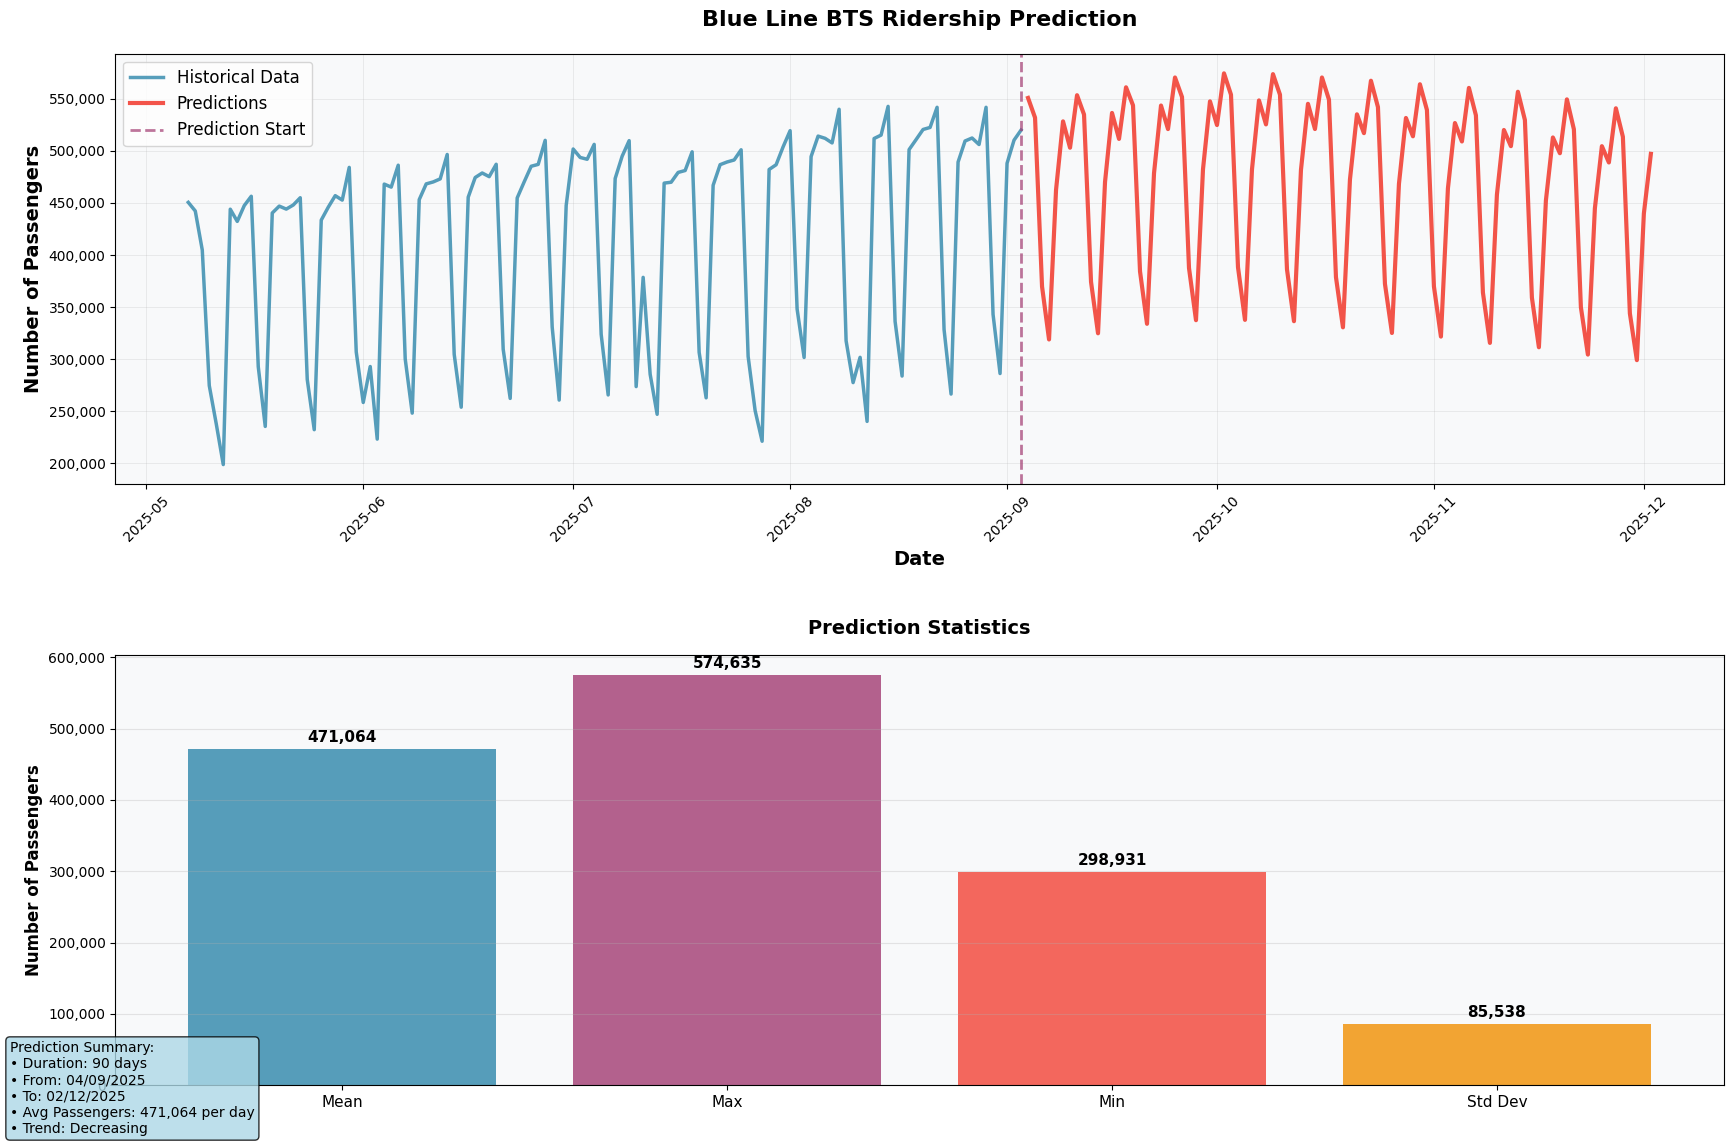

üìä BTS Blue Line Ridership Prediction Statistics
üóìÔ∏è  Prediction Period: 90 days
üìÖ Start Date: 04 September 2025
üìÖ End Date: 02 December 2025
üë• Average Passengers: 471,064 per day
üìà Maximum: 574,635 on 02/10/2025
üìâ Minimum: 298,931 on 30/11/2025
üìä Standard Deviation: 85,538
üìã Total Passengers: 42,395,723


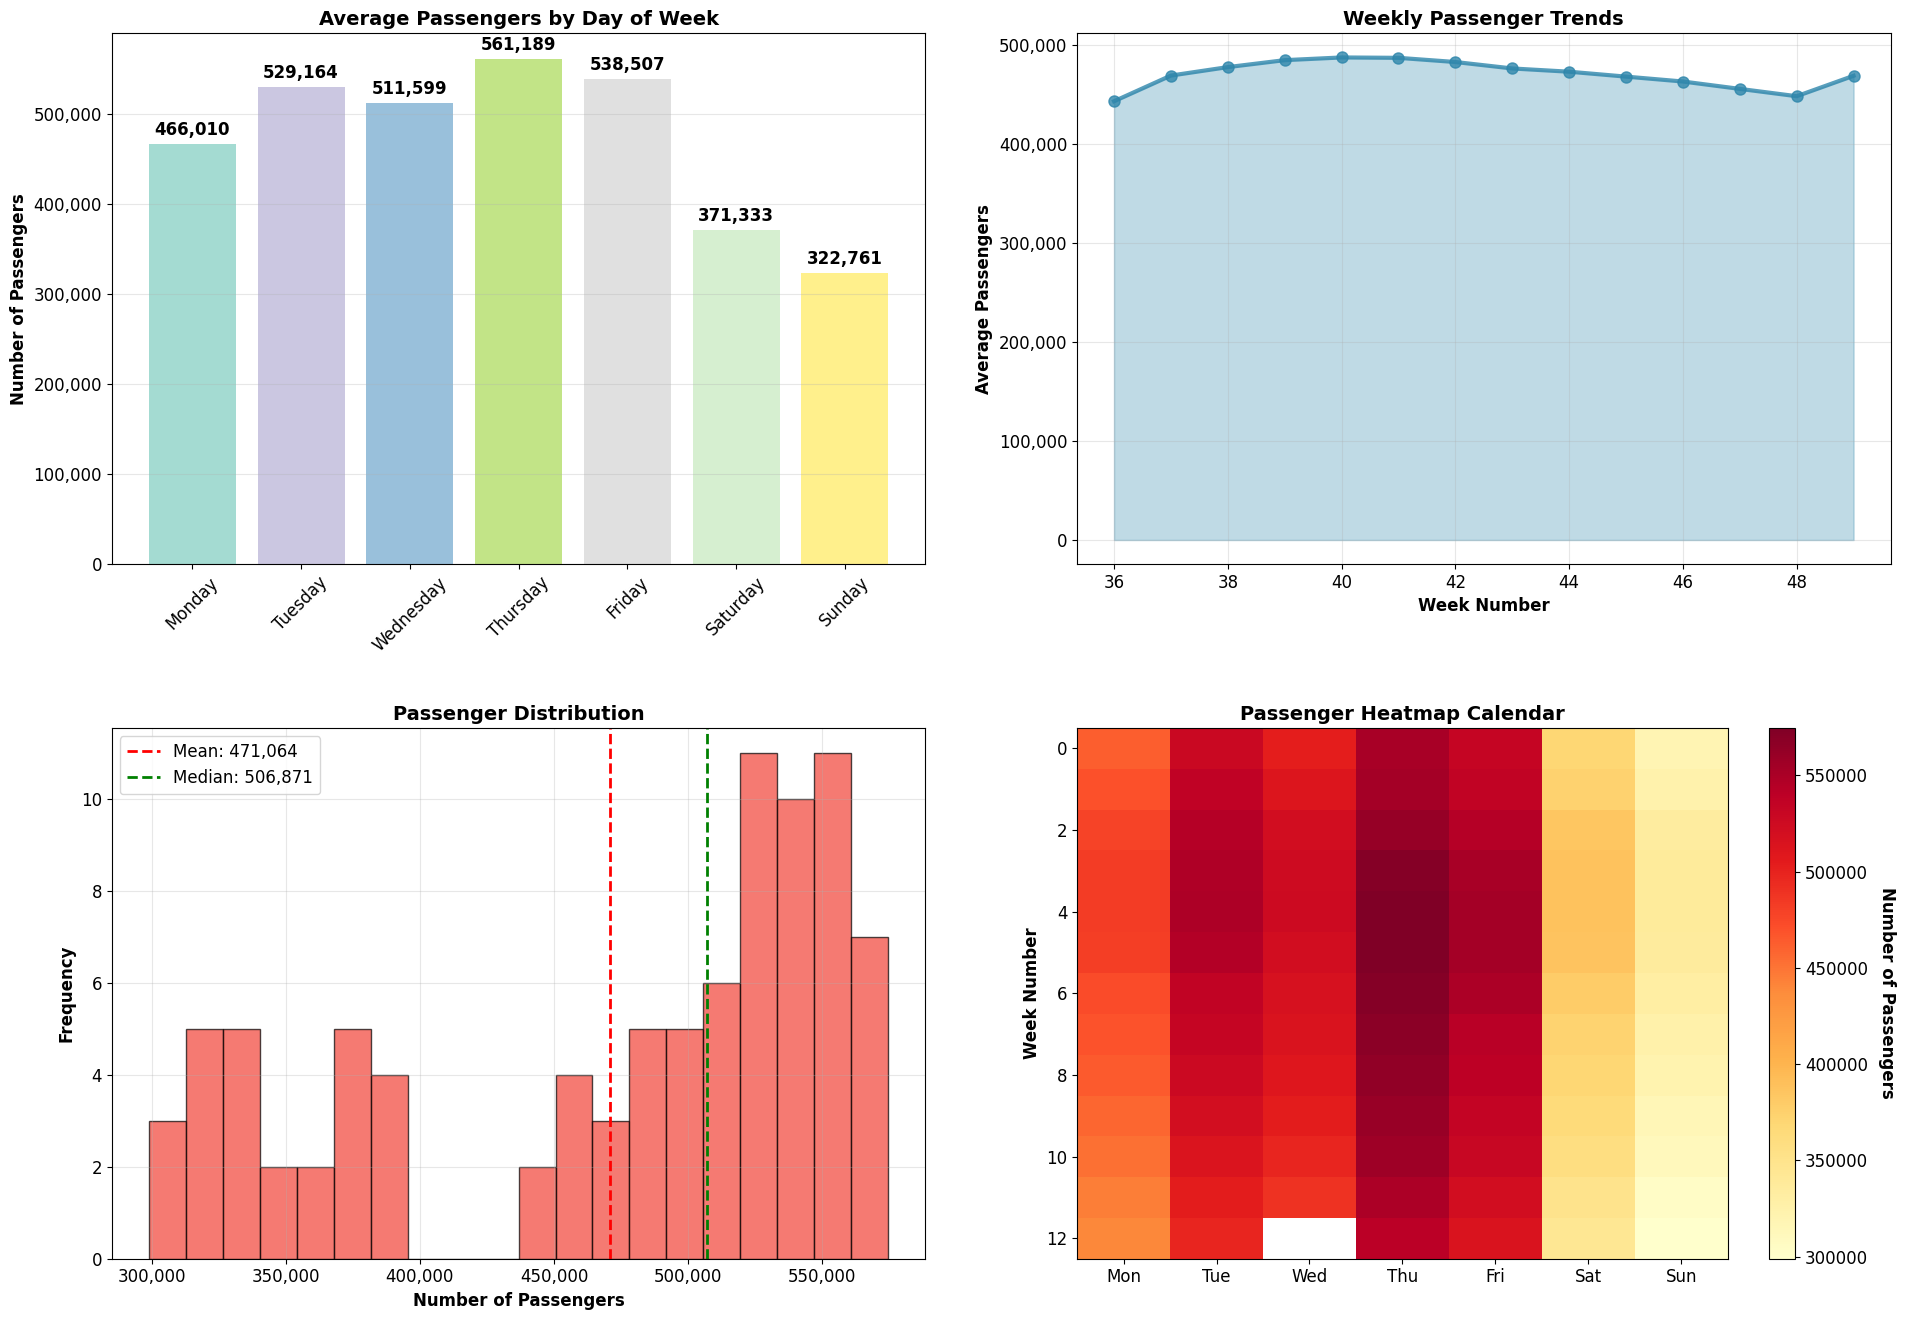

‚úÖ Analysis Complete with English labels!


In [9]:
# ‡∏ó‡∏î‡∏™‡∏≠‡∏ö‡∏Å‡∏≤‡∏£‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡∏†‡∏≤‡∏©‡∏≤‡∏≠‡∏±‡∏á‡∏Å‡∏§‡∏© (‡πÅ‡∏Å‡πâ‡∏õ‡∏±‡∏ç‡∏´‡∏≤‡∏™‡∏µ‡πà‡πÄ‡∏´‡∏•‡∏µ‡πà‡∏¢‡∏°)
# ‡πÉ‡∏ä‡πâ‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏à‡∏≤‡∏Å‡πÇ‡∏ü‡∏•‡πÄ‡∏î‡∏≠‡∏£‡πå checkpoints
predictions = predict(model_path='checkpoints/best_model.pth', num_predictions=90)
if predictions is not None:
    visualize_predictions_en(predictions)
    df_analysis = analyze_daily_patterns_en(predictions)
    print("‚úÖ Analysis Complete with English labels!")